## Problem statement:
To build a CNN based model which can accurately detect COVID-19 virus from chest X-ray images using Convolutional Neural Network.

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
np.random.seed(123) # for reproducibility
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(123)
import glob
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from imutils import paths
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc
import random
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 50000, "display.max_columns", None, "display.max_colwidth", None,"display.max_info_columns", 5000)

###Mounting the data to Google drive to use Google Colab for running this code

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Defining the path for image files

data_dir = pathlib.Path("/content/gdrive/My Drive/Datasets/COVID-ChestXray-15k-dataset/")

data_dir_normal = pathlib.Path("/content/gdrive/My Drive/Datasets/COVID-ChestXray-15k-dataset/NORMAL/")
data_dir_pneumonia = pathlib.Path("/content/gdrive/My Drive/Datasets/COVID-ChestXray-15k-dataset/PNEUMONIA/")
data_dir_covid = pathlib.Path("/content/gdrive/My Drive/Datasets/COVID-ChestXray-15k-dataset/COVID/")


14999
5000
5000
4999


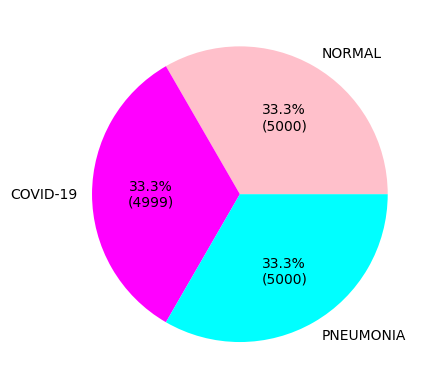

In [ ]:
# Print the count of Images in Dataset
image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)
image_count_normal = len(list(data_dir_normal.glob('*.*')))
print(image_count_normal)
image_count_pneumonia = len(list(data_dir_pneumonia.glob('*.*')))
print(image_count_pneumonia)
image_count_covid = len(list(data_dir_covid.glob('*.*')))
print(image_count_covid)

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format


chart_count = np.array([image_count_normal, image_count_covid, image_count_pneumonia])
labels = 'NORMAL', 'COVID-19', 'PNEUMONIA'
plt.pie(chart_count, labels=labels, autopct= autopct_format(chart_count) , colors = ['pink','magenta', 'cyan' ] )
plt.show()


###Visualize the Chest X-ray images from each of the three classes


####Plot the NORMAL Chest x-ray images

/content/gdrive/My Drive/Datasets/COVID-ChestXray-15k-dataset/NORMAL
['Normal-87.png', 'Normal-849.png', 'Normal-850.png', 'Normal-843.png', 'Normal-866.png', 'Normal-877.png', 'Normal-858.png', 'Normal-861.png', 'Normal-884.png', 'Normal-846.png', 'Normal-876.png', 'Normal-871.png', 'Normal-868.png', 'Normal-878.png', 'Normal-85.png', 'Normal-870.png', 'Normal-856.png', 'Normal-844.png', 'Normal-859.png', 'Normal-86.png', 'Normal-874.png', 'Normal-864.png', 'Normal-869.png', 'Normal-882.png', 'Normal-879.png', 'Normal-851.png', 'Normal-841.png', 'Normal-855.png', 'Normal-872.png', 'Normal-845.png', 'Normal-867.png', 'Normal-842.png', 'Normal-883.png', 'Normal-854.png', 'Normal-862.png', 'Normal-873.png', 'Normal-847.png', 'Normal-88.png', 'Normal-881.png', 'Normal-852.png', 'Normal-857.png', 'Normal-865.png', 'Normal-888.png', 'Normal-932.png', 'Normal-930.png', 'Normal-913.png', 'Normal-906.png', 'Normal-905.png', 'Normal-912.png', 'Normal-921.png', 'Normal-93.png', 'Normal-9.png', '

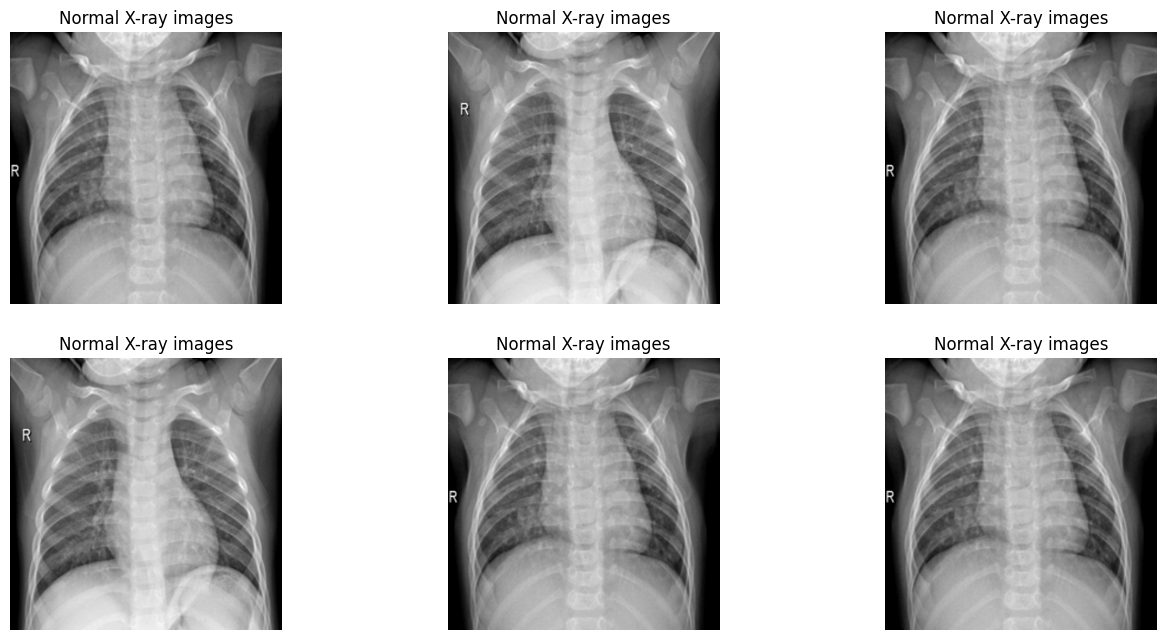

In [ ]:
plt.figure(figsize=(16,12))
# Path list
dir_normal = os.listdir(data_dir_normal)

for i in range(6):
    ran = random.choice((1,30))

    normal_image = [os.path.join(data_dir_normal, f) for f in dir_normal[ran:ran+1]]

    rand_image = random.choice(normal_image)
    print(normal_image)
    print (rand_image)
    plt.subplot(3, 3, i+1)
    img = plt.imread(rand_image)
    plt.imshow(img,cmap = 'gray')
    plt.axis(False)
    plt.title('Normal X-ray images')
plt.show()

#### Plot the COVID-19 Chest x-ray images

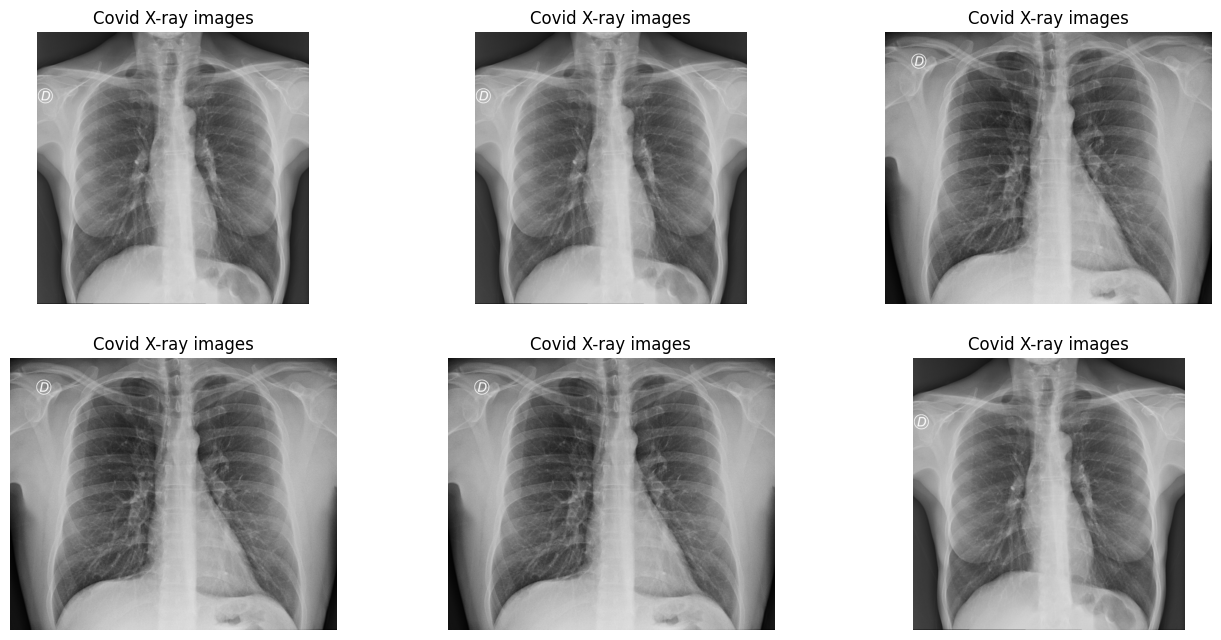

In [ ]:
plt.figure(figsize=(16,12))
# Path list
dir_covid = os.listdir(data_dir_covid)

for i in range(6):
    ran = random.choice((1,30))

    covid_image = [os.path.join(data_dir_covid, f) for f in dir_covid[ran:ran+1]]

    rand_image = random.choice(covid_image)

    plt.subplot(3, 3, i+1)
    img = plt.imread(rand_image)
    plt.imshow(img,cmap = 'gray')
    plt.axis(False)
    plt.title('Covid X-ray images')
plt.show()

#### Plot the PNEUMONIA Chest x-ray images

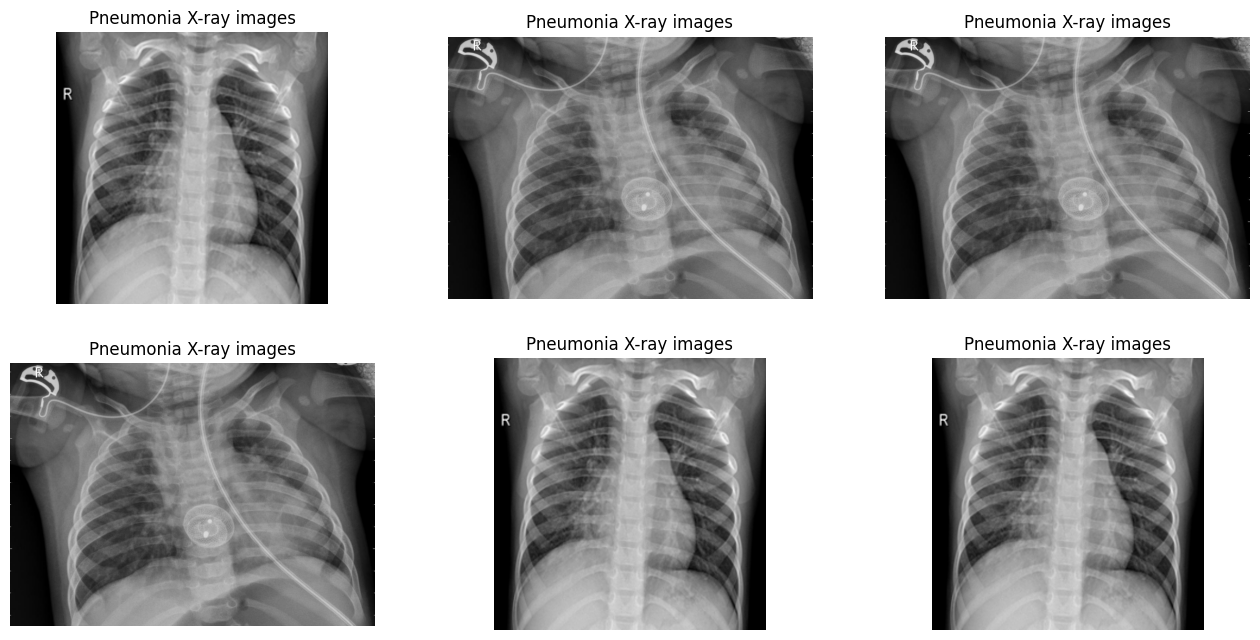

In [ ]:
plt.figure(figsize=(16,12))
# Path list
dir_pneumonia = os.listdir(data_dir_pneumonia)

for i in range(6):
    ran = random.choice((1,30))

    pneumonia_image = [os.path.join(data_dir_pneumonia, f) for f in dir_pneumonia[ran:ran+1]]

    rand_image = random.choice(pneumonia_image)

    plt.subplot(3, 3, i+1)
    img = plt.imread(rand_image)
    plt.imshow(img,cmap = 'gray')
    plt.axis(False)
    plt.title('Pneumonia X-ray images')
plt.show()

### Images pre-processing

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
image_size = (224, 224)
channels=3
num_classes = 3   ## The number of target classifications of images

####Read and resize the images, Create image and label array.Normalize the images.

In [ ]:
## Class - Normal
imagePaths = list(paths.list_images(data_dir_normal))
data = []
labels = []
for imagePath in imagePaths:
    label = 0
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)

    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
data = np.array(data) /255
labels = np.array(labels)


In [ ]:
data.shape


(5000, 224, 224, 3)

In [ ]:
labels.shape

(5000,)

In [ ]:
labels

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
## Class - Covid
imagePaths1 = list(paths.list_images(data_dir_covid))
data1 = []
labels1 = []
for imagePath in imagePaths1:
    label1 = 1
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)

    image = cv2.resize(image, (224, 224))
    data1.append(image)
    labels1.append(label1)

data1 = np.array(data1) / 255
labels1 = np.array(labels1)

In [ ]:
data1.shape

In [ ]:
labels1.shape

In [ ]:
labels1

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
## Class - Pneumonia
imagePaths2 = list(paths.list_images(data_dir_pneumonia))
data2 = []
labels2 = []
for imagePath in imagePaths2:
    label2 = 2
    image = cv2.imread(imagePath)

    image = cv2.resize(image, (224, 224))
    data2.append(image)
    labels2.append(label2)
data2 = np.array(data2) / 255
labels2 = np.array(labels2)

In [ ]:
data2.shape

(5000, 224, 224, 3)

In [ ]:
labels2.shape

(5000,)

In [ ]:
labels2

array([2, 2, 2, ..., 2, 2, 2])

#### Concatenate the image arrays of all classes together in one dataset

In [ ]:
dataset = np.concatenate((data, data1, data2), axis=0)

#### Concatenate the label arrays of all classes together in one dataset

In [ ]:
label = np.concatenate((labels, labels1, labels2), axis=0)

In [ ]:
label


####Train and Test Split.
Train, validation and test images are split into ratio of 64%, 16% and 20%

In [ ]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(dataset, label, test_size=0.20, stratify=label, random_state=42)

In [ ]:
(trainX, valX, trainY, valY) = train_test_split(trainX, trainY, test_size=0.20, random_state=42)


In [ ]:
len(trainX)


9599

In [ ]:
len(trainY)

9599

In [ ]:
len(valY)

2400

In [ ]:
len(valX)

2400

In [ ]:
len(testX)

3000

In [ ]:
len(testY)

3000

In [ ]:
trainY

array([2, 2, 2, ..., 2, 2, 1])

###Create the model
####Create a CNN model, which can accurately detect 3 classes present in the dataset.

####Experiment 1 :VGG19; SGD; Dense layer=512 ,  learning_rate = 1e-2, decay_rate = 0.9, decay_steps = 10000, epoch = 30

In [ ]:
from keras.applications.vgg19 import VGG19 ## pretrained model

base_model0= VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

model0 = Sequential()
model0.add(base_model0)

for layer in model0.layers:
    layer.trainable = False


model0.add(keras.layers.Flatten(input_shape=(224,224,3)))
model0.add(Dense(512,activation='relu'))


## Final Dense layer with activation fumction = 'softmax' ( for classification)

model0.add(tf.keras.layers.Dense(3, activation = 'softmax'))

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded

epochs = 30

initial_learning_rate = 1e-2

learning_rate_decay_factor = 0.9  ##(final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model0.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               12845568  
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 32,871,491
Trainable params: 12,847,107
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
epochs = 30
#LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=1, patience=4, min_lr = 0.00001)
## Train the model for 30 epochs

history = model0.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32
)

Epoch 1/30
300/300 [==============================] - 15s 43ms/step - loss: 0.7175 - accuracy: 0.7154 - val_loss: 0.3567 - val_accuracy: 0.8913
Epoch 2/30
300/300 [==============================] - 10s 33ms/step - loss: 0.3465 - accuracy: 0.8673 - val_loss: 0.2319 - val_accuracy: 0.9179
Epoch 3/30
300/300 [==============================] - 10s 33ms/step - loss: 0.3463 - accuracy: 0.8754 - val_loss: 0.2697 - val_accuracy: 0.9100
Epoch 4/30
300/300 [==============================] - 10s 33ms/step - loss: 0.2885 - accuracy: 0.8931 - val_loss: 0.2199 - val_accuracy: 0.9267
Epoch 5/30
300/300 [==============================] - 10s 33ms/step - loss: 0.2842 - accuracy: 0.8953 - val_loss: 0.1790 - val_accuracy: 0.9358
Epoch 6/30
300/300 [==============================] - 10s 33ms/step - loss: 0.2212 - accuracy: 0.9186 - val_loss: 0.2226 - val_accuracy: 0.9104
Epoch 7/30
300/300 [==============================] - 10s 33ms/step - loss: 0.2005 - accuracy: 0.9282 - val_loss: 0.2171 - val_accuracy:

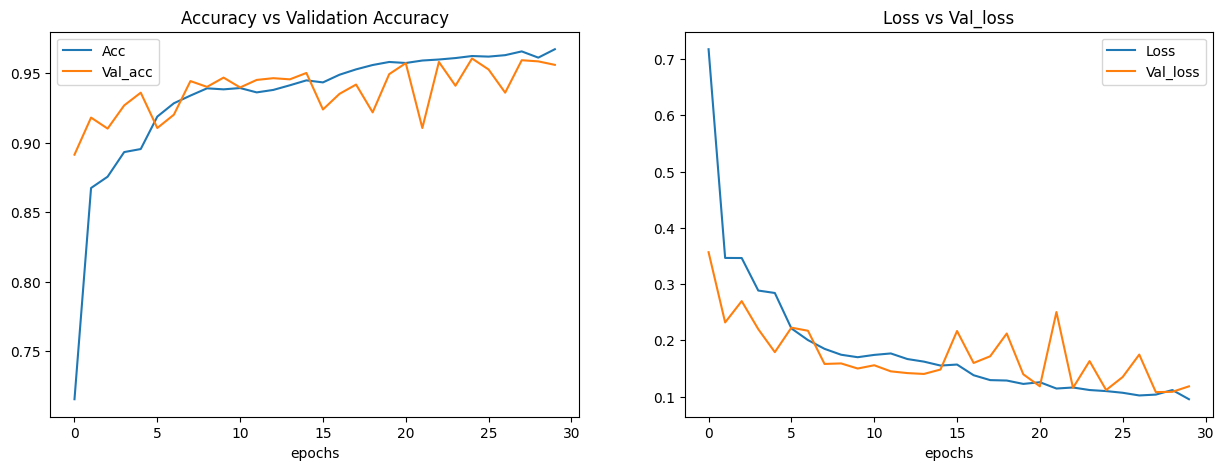

Training accuracy 0.9326075593630473
Validation accuracy 0.9376250008742014


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

####Experiment 2 :VGG19; SGD; Dense layer=512 , Dropout =0.5, learning_rate = 1e-2, decay_rate = 0.9, decay_steps = 10000, epoch = 30

####Define the model

In [ ]:
from keras.applications.vgg19 import VGG19 ## pretrained model

base_model1= VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

model1 = Sequential()
model1.add(base_model1)

for layer in model1.layers:
    layer.trainable = False


model1.add(keras.layers.Flatten(input_shape=(224,224,3)))
model1.add(Dense(512,activation='relu'))
model1.add(Dropout(0.5))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

model1.add(tf.keras.layers.Dense(3, activation = 'softmax'))




80134624/80134624 [==============================] - 5s 0us/step


####Compile the model

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded

epochs = 30

initial_learning_rate = 1e-2
##final_learning_rate = 0.00001
learning_rate_decay_factor = 0.9  ##(final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model1.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 32,871,491
Trainable params: 12,847,107
Non-trainable params: 20,024,384
_________________________________________________________________


####Train the model

In [ ]:
epochs = 30
#LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=1, patience=4, min_lr = 0.00001)
## Train the model for 30 epochs

history = model1.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32
)



Epoch 1/30
300/300 [==============================] - 23s 44ms/step - loss: 0.8421 - accuracy: 0.6638 - val_loss: 0.4848 - val_accuracy: 0.8354
Epoch 2/30
300/300 [==============================] - 10s 34ms/step - loss: 0.4372 - accuracy: 0.8359 - val_loss: 0.2483 - val_accuracy: 0.9154
Epoch 3/30
300/300 [==============================] - 10s 34ms/step - loss: 0.3727 - accuracy: 0.8590 - val_loss: 0.2252 - val_accuracy: 0.9129
Epoch 4/30
300/300 [==============================] - 10s 34ms/step - loss: 0.3165 - accuracy: 0.8853 - val_loss: 0.2012 - val_accuracy: 0.9254
Epoch 5/30
300/300 [==============================] - 10s 34ms/step - loss: 0.3039 - accuracy: 0.8876 - val_loss: 0.2034 - val_accuracy: 0.9250
Epoch 6/30
300/300 [==============================] - 10s 34ms/step - loss: 0.2818 - accuracy: 0.8999 - val_loss: 0.2259 - val_accuracy: 0.9029
Epoch 7/30
300/300 [==============================] - 10s 34ms/step - loss: 0.2718 - accuracy: 0.8984 - val_loss: 0.1953 - val_accuracy:

#### Visualizing training results

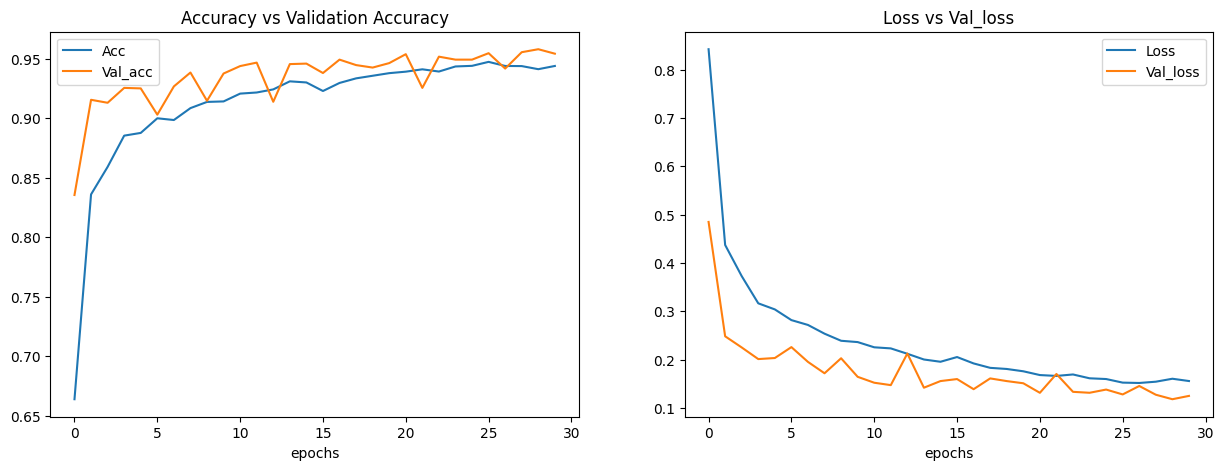

Training accuracy 0.9126367330551147
Validation accuracy 0.934763890504837


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

####Experiment 3 : VGG19, SGD, Added dropout= 0.25 before Dense layer of 512.   Dropout = 0.5 after dense layer, learning_rate = 1e-2, decay_rate = 0.9, steps_per_epoch = 10000, epoch = 30, callback with EarlyStopping

In [ ]:
from keras.applications.vgg19 import VGG19 ## pretrained model

base_model2= VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

model2 = Sequential()
model2.add(base_model2)

for layer in model2.layers:
    layer.trainable = False


model2.add(keras.layers.Flatten(input_shape=(224,224,3)))
model2.add(Dropout(0.25))
model2.add(Dense(512,activation='relu'))
model2.add(Dropout(0.5))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

model2.add(tf.keras.layers.Dense(3, activation = 'softmax'))


80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-2
##final_learning_rate = 0.00001
learning_rate_decay_factor = 0.9  ##(final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


callbacks = [EarlyStopping(monitor='val_loss', patience=10),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model2.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 32,871,491
Trainable params: 12,847,107


In [ ]:
epochs = 30
## Train the model for 30 epochs

history = model2.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)


Epoch 1/30
300/300 [==============================] - 14s 43ms/step - loss: 0.8473 - accuracy: 0.6659 - val_loss: 0.4849 - val_accuracy: 0.7996
Epoch 2/30
300/300 [==============================] - 10s 35ms/step - loss: 0.4379 - accuracy: 0.8302 - val_loss: 0.2515 - val_accuracy: 0.9058
Epoch 3/30
300/300 [==============================] - 10s 35ms/step - loss: 0.3563 - accuracy: 0.8682 - val_loss: 0.2493 - val_accuracy: 0.9125
Epoch 4/30
300/300 [==============================] - 10s 35ms/step - loss: 0.3183 - accuracy: 0.8826 - val_loss: 0.2115 - val_accuracy: 0.9179
Epoch 5/30
300/300 [==============================] - 10s 35ms/step - loss: 0.2902 - accuracy: 0.8914 - val_loss: 0.1983 - val_accuracy: 0.9292
Epoch 6/30
300/300 [==============================] - 10s 34ms/step - loss: 0.2640 - accuracy: 0.9018 - val_loss: 0.2022 - val_accuracy: 0.9158
Epoch 7/30
300/300 [==============================] - 10s 34ms/step - loss: 0.2425 - accuracy: 0.9106 - val_loss: 0.2543 - val_accuracy:

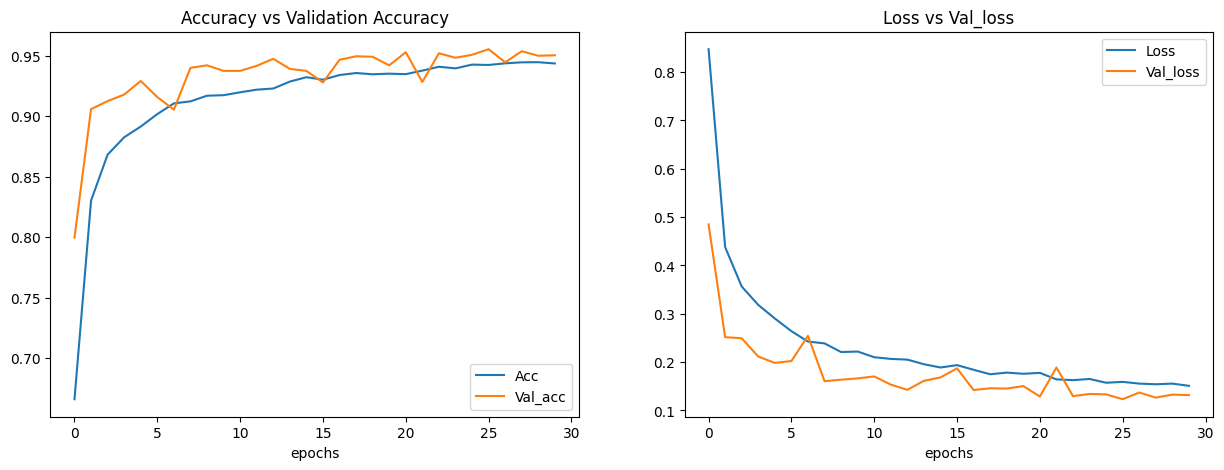

Training accuracy 0.9135847449302673
Validation accuracy 0.9337083359559377


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

####Experiment 4 : VGG19, SGD, Dropout= 0.25 before Dense layer of 512.   Dropout = 0.5 after dense layer, learning_rate = 1e-2, decay_rate = 0.9, steps_per_epoch = 10000, epoch = 100, EarlyStopping

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = model2.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 13s 42ms/step - loss: 0.1533 - accuracy: 0.9420 - val_loss: 0.1203 - val_accuracy: 0.9542
Epoch 2/100
300/300 [==============================] - 11s 35ms/step - loss: 0.1507 - accuracy: 0.9434 - val_loss: 0.1159 - val_accuracy: 0.9571
Epoch 3/100
300/300 [==============================] - 10s 34ms/step - loss: 0.1479 - accuracy: 0.9442 - val_loss: 0.1343 - val_accuracy: 0.9471
Epoch 4/100
300/300 [==============================] - 10s 34ms/step - loss: 0.1382 - accuracy: 0.9513 - val_loss: 0.1246 - val_accuracy: 0.9508
Epoch 5/100
300/300 [==============================] - 10s 34ms/step - loss: 0.1376 - accuracy: 0.9492 - val_loss: 0.1182 - val_accuracy: 0.9563
Epoch 6/100
300/300 [==============================] - 10s 34ms/step - loss: 0.1336 - accuracy: 0.9524 - val_loss: 0.1337 - val_accuracy: 0.9458
Epoch 7/100
300/300 [==============================] - 10s 34ms/step - loss: 0.1408 - accuracy: 0.9485 - val_loss: 0.1201 - val_ac

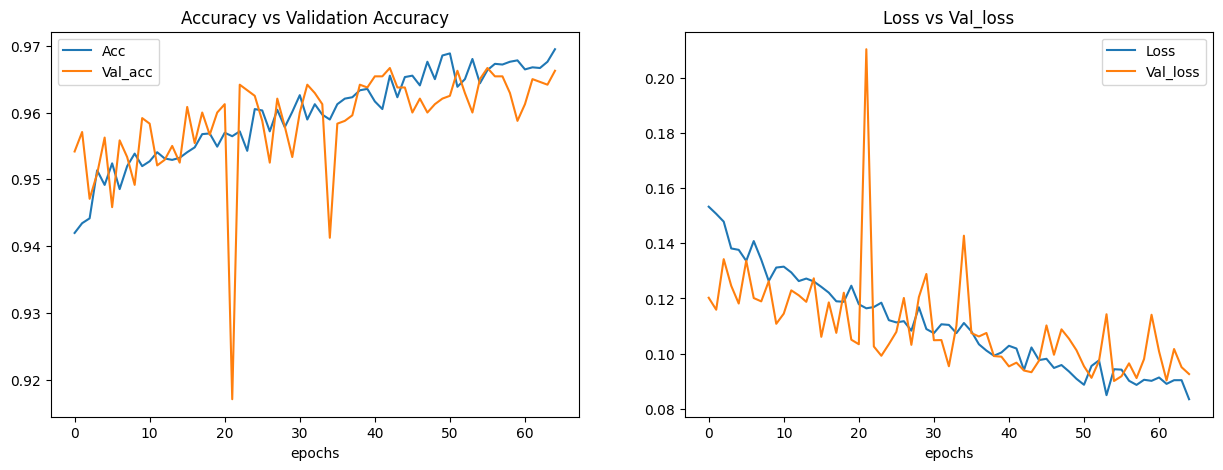

Training accuracy 0.9596400205905621
Validation accuracy 0.9588781989537752


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))


####Experiment 5 : VGG19, SGD, Added dropout= 0.25 before Dense layer of 512.   Dropout = 0.5 after dense layer, learning_rate = 1e-2, decay_rate = 0.9, decay_steps = 10000, epoch = 100, Momentum = 0.9, EarlyStopping

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-2

learning_rate_decay_factor = 0.9  ##(final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

## Pateince changed to 8
callbacks = [EarlyStopping(monitor='val_loss', patience=10),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

model2.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 32,871,491
Trainable params: 12,847,107
No

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = model2.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 24s 46ms/step - loss: 1.1896 - accuracy: 0.3718 - val_loss: 1.1017 - val_accuracy: 0.3388
Epoch 2/100
300/300 [==============================] - 11s 36ms/step - loss: 1.0992 - accuracy: 0.3373 - val_loss: 1.1009 - val_accuracy: 0.3154
Epoch 3/100
300/300 [==============================] - 11s 35ms/step - loss: 1.0993 - accuracy: 0.3278 - val_loss: 1.0997 - val_accuracy: 0.3154
Epoch 4/100
300/300 [==============================] - 10s 34ms/step - loss: 1.0994 - accuracy: 0.3282 - val_loss: 1.1005 - val_accuracy: 0.3388
Epoch 5/100
300/300 [==============================] - 10s 34ms/step - loss: 1.0991 - accuracy: 0.3380 - val_loss: 1.0999 - val_accuracy: 0.3154
Epoch 6/100
300/300 [==============================] - 11s 36ms/step - loss: 1.0991 - accuracy: 0.3280 - val_loss: 1.0985 - val_accuracy: 0.3458
Epoch 7/100
300/300 [==============================] - 11s 35ms/step - loss: 1.0992 - accuracy: 0.3297 - val_loss: 1.0985 - val_ac

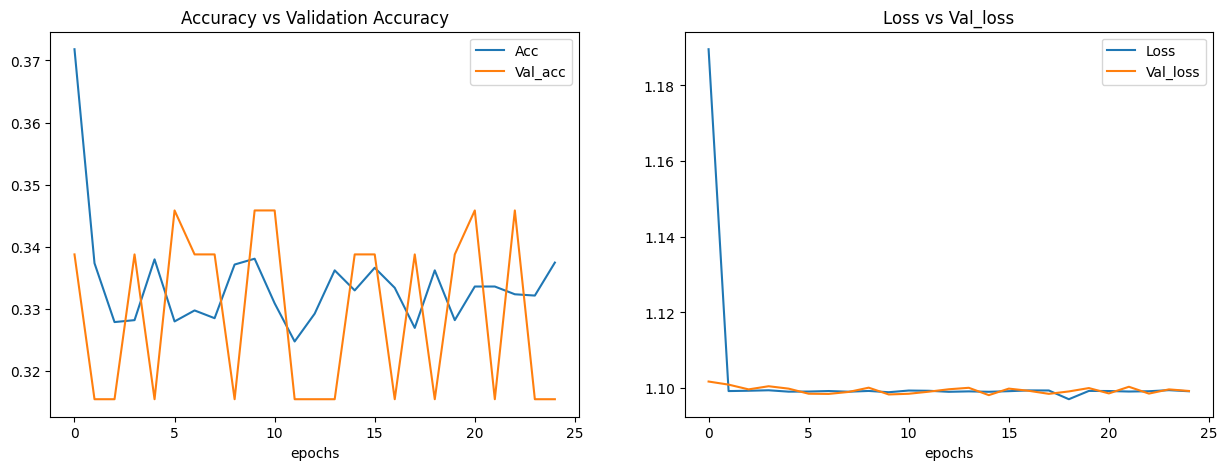

Training accuracy 0.3339431202411652
Validation accuracy 0.32896666646003725


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))


####Experiment 6: VGG19, SGD, Added dropout= 0.25 before Dense layer of 512.   Dropout = 0.5 after dense layer of 512, Additional dense layer of 128, learning_rate = 1e-2, decay_rate = 0.9, steps_per_epoch = 10000, epoch = 100,EarlyStopping

In [ ]:
from keras.applications.vgg19 import VGG19 ## pretrained model

base_model7= VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

model7 = Sequential()
model7.add(base_model7)

for layer in model7.layers:
    layer.trainable = False


model7.add(keras.layers.Flatten(input_shape=(224,224,3)))
model7.add(Dropout(0.25))
model7.add(Dense(512,activation='relu'))
model7.add(Dropout(0.5))
model7.add(Dense(128,activation='relu'))       ## New layer

## Final Dense layer with activation fumction = 'softmax' ( for classification)

model7.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-2

learning_rate_decay_factor = 0.9  ##(final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

## Pateince changed to 8
callbacks = [EarlyStopping(monitor='val_loss', patience=10),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model7.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_2 (Dropout)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 3)                

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = model7.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 15s 44ms/step - loss: 0.8475 - accuracy: 0.6352 - val_loss: 0.3813 - val_accuracy: 0.8771
Epoch 2/100
300/300 [==============================] - 11s 36ms/step - loss: 0.4501 - accuracy: 0.8263 - val_loss: 0.2617 - val_accuracy: 0.9067
Epoch 3/100
300/300 [==============================] - 11s 36ms/step - loss: 0.3603 - accuracy: 0.8653 - val_loss: 0.2469 - val_accuracy: 0.9117
Epoch 4/100
300/300 [==============================] - 11s 36ms/step - loss: 0.3139 - accuracy: 0.8833 - val_loss: 0.2258 - val_accuracy: 0.9192
Epoch 5/100
300/300 [==============================] - 11s 36ms/step - loss: 0.2880 - accuracy: 0.8906 - val_loss: 0.2038 - val_accuracy: 0.9258
Epoch 6/100
300/300 [==============================] - 11s 36ms/step - loss: 0.2760 - accuracy: 0.8986 - val_loss: 0.1983 - val_accuracy: 0.9267
Epoch 7/100
300/300 [==============================] - 10s 34ms/step - loss: 0.2513 - accuracy: 0.9059 - val_loss: 0.2206 - val_ac

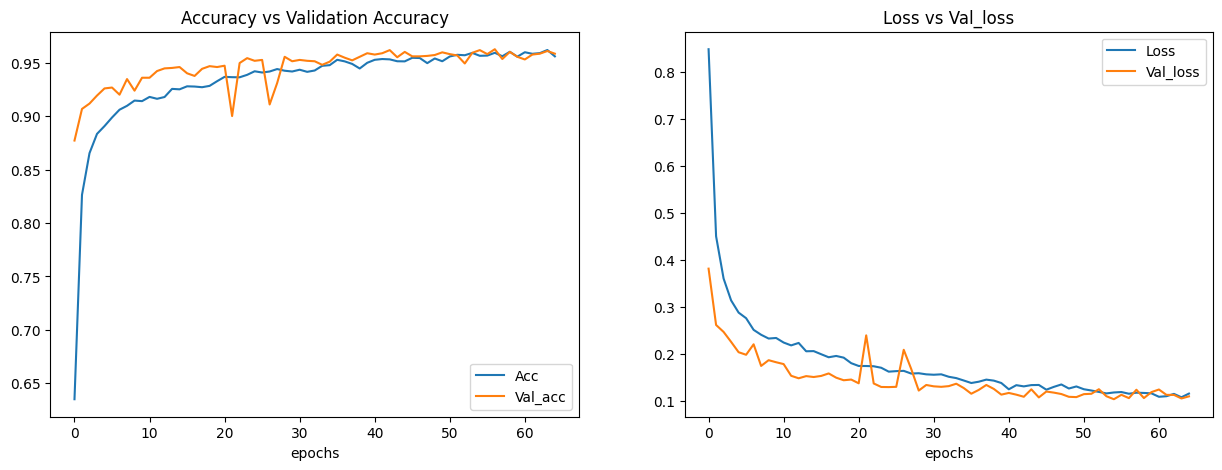

Training accuracy 0.9330603379469652
Validation accuracy 0.9459038450167729


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

#### Experiment 7 - VGG19, SGD, Added dropout= 0.25 before Dense layer of 512.   Dropout = 0.5 after dense layer of 512, Additional dense layer of 128, Dropout=0.25 after dense layer of 128, learning_rate = 1e-2, decay_rate = 0.9, steps_per_epoch = 10000, epoch = 100, EarlyStopping

In [ ]:
from keras.applications.vgg19 import VGG19 ## pretrained model

base_model8= VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

model8 = Sequential()
model8.add(base_model8)

for layer in model8.layers:
    layer.trainable = False


model8.add(keras.layers.Flatten(input_shape=(224,224,3)))
model8.add(Dropout(0.25))
model8.add(Dense(512,activation='relu'))
model8.add(Dropout(0.5))
model8.add(Dense(128,activation='relu'))
model8.add(Dropout(0.25))              ## New layer

## Final Dense layer with activation fumction = 'softmax' ( for classification)

model8.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-2

learning_rate_decay_factor = 0.9  ##(final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


callbacks = [EarlyStopping(monitor='val_loss', patience=10),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model8.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model8.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_4 (Dropout)         (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dropout_6 (Dropout)         (None, 128)              

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = model8.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 14s 42ms/step - loss: 0.8469 - accuracy: 0.6252 - val_loss: 0.4238 - val_accuracy: 0.8692
Epoch 2/100
300/300 [==============================] - 11s 36ms/step - loss: 0.4678 - accuracy: 0.8168 - val_loss: 0.2776 - val_accuracy: 0.8933
Epoch 3/100
300/300 [==============================] - 11s 36ms/step - loss: 0.3923 - accuracy: 0.8482 - val_loss: 0.2510 - val_accuracy: 0.9075
Epoch 4/100
300/300 [==============================] - 11s 36ms/step - loss: 0.3336 - accuracy: 0.8752 - val_loss: 0.2150 - val_accuracy: 0.9142
Epoch 5/100
300/300 [==============================] - 10s 35ms/step - loss: 0.3130 - accuracy: 0.8833 - val_loss: 0.2163 - val_accuracy: 0.9142
Epoch 6/100
300/300 [==============================] - 11s 36ms/step - loss: 0.2893 - accuracy: 0.8966 - val_loss: 0.1877 - val_accuracy: 0.9275
Epoch 7/100
300/300 [==============================] - 11s 36ms/step - loss: 0.2714 - accuracy: 0.8997 - val_loss: 0.1852 - val_ac

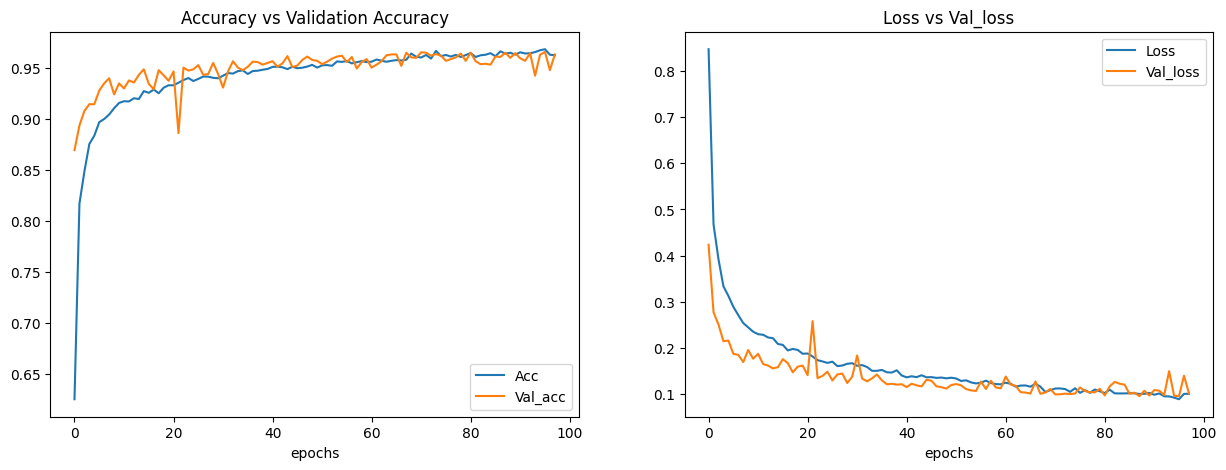

Training accuracy 0.9413735708411859
Validation accuracy 0.9492772075594688


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

#### Experiment 8 - VGG19, SGD, Added dropout= 0.25 before Dense layer of 512.   Dropout = 0.5 after dense layer of 512, Additional dense layer of 128, Dropout=0.25 after dense layer of 128, Batchnormalization, learning_rate = 1e-2, decay_rate = 0.9, steps_per_epoch = 10000, epoch = 100, EarlyStopping

In [ ]:
from keras.applications.vgg19 import VGG19 ## pretrained model

base_model9= VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

model9 = Sequential()
model9.add(base_model9)

for layer in model9.layers:
    layer.trainable = False


model9.add(keras.layers.Flatten(input_shape=(224,224,3)))
model9.add(Dropout(0.25))
model9.add(Dense(512,activation='relu'))
model9.add(BatchNormalization())               ## New layer
model9.add(Dropout(0.5))
model9.add(Dense(128,activation='relu'))
model9.add(Dropout(0.25))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

model9.add(tf.keras.layers.Dense(3, activation = 'softmax'))

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-2
##final_learning_rate = 0.00001
learning_rate_decay_factor = 0.9  ##(final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

## Pateince changed to 8
callbacks = [EarlyStopping(monitor='val_loss', patience=10),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model9.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model9.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = model9.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 24s 45ms/step - loss: 0.4206 - accuracy: 0.8396 - val_loss: 0.1834 - val_accuracy: 0.9333
Epoch 2/100
300/300 [==============================] - 11s 35ms/step - loss: 0.2812 - accuracy: 0.8963 - val_loss: 0.1586 - val_accuracy: 0.9408
Epoch 3/100
300/300 [==============================] - 10s 34ms/step - loss: 0.2391 - accuracy: 0.9134 - val_loss: 0.1654 - val_accuracy: 0.9383
Epoch 4/100
300/300 [==============================] - 11s 36ms/step - loss: 0.2100 - accuracy: 0.9227 - val_loss: 0.1319 - val_accuracy: 0.9567
Epoch 5/100
300/300 [==============================] - 10s 34ms/step - loss: 0.1976 - accuracy: 0.9284 - val_loss: 0.1433 - val_accuracy: 0.9475
Epoch 6/100
300/300 [==============================] - 11s 35ms/step - loss: 0.1940 - accuracy: 0.9279 - val_loss: 0.1224 - val_accuracy: 0.9567
Epoch 7/100
300/300 [==============================] - 10s 34ms/step - loss: 0.1830 - accuracy: 0.9353 - val_loss: 0.1273 - val_ac

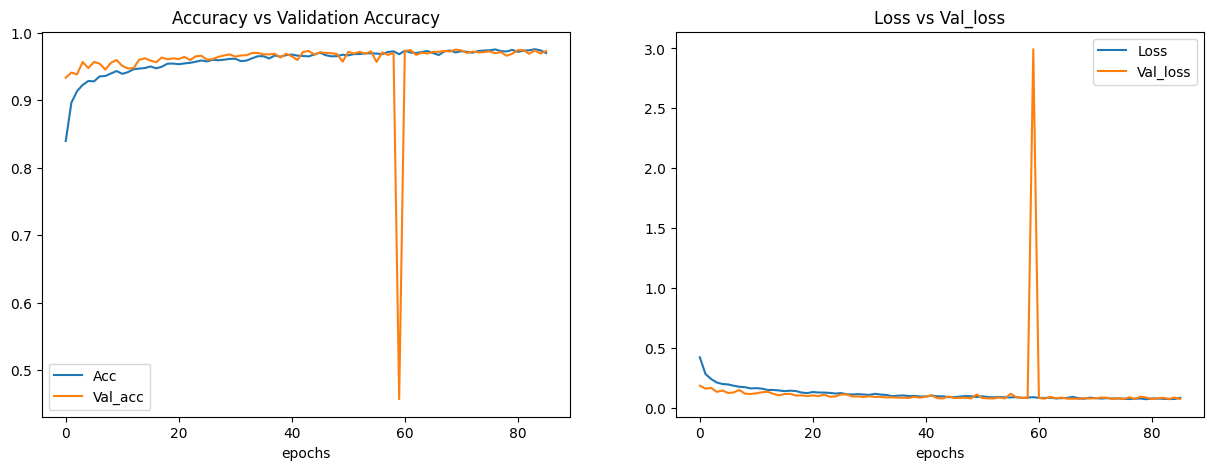

Training accuracy 0.9593235240426174
Validation accuracy 0.9589389562606812


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

#### Make Predictions against Test set

In [ ]:
# make predictions on the testing set
y_pred = model9.predict(testX, batch_size=32)
print(y_pred.shape  )
print(testY.shape)

94/94 [==============================] - 3s 32ms/step
(3000, 3)
(3000,)


(3000, 3)
(3000, 3)


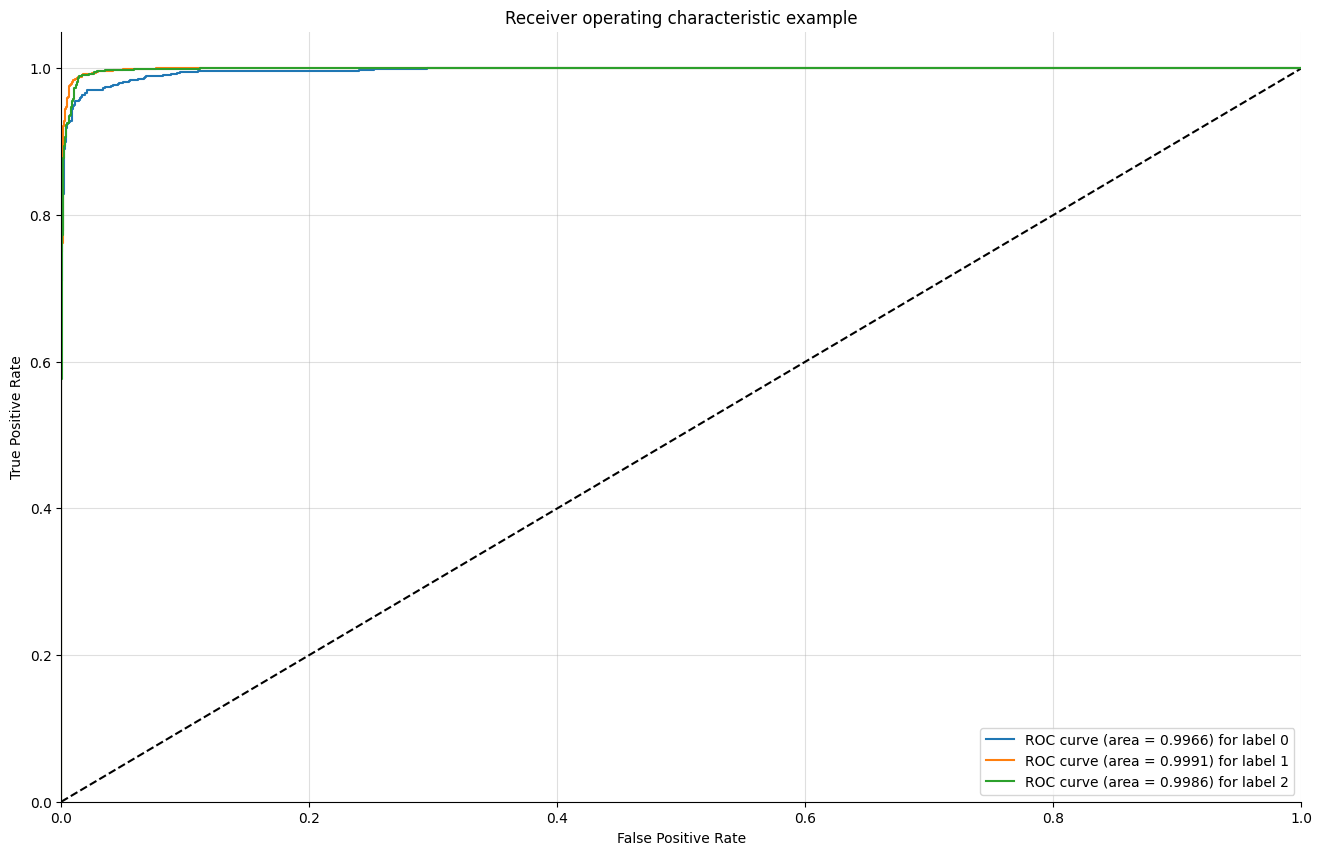

In [ ]:
from sklearn.preprocessing import label_binarize
def plot_multiclass_roc( testY, y_pred, n_classes, figsize=(17, 6)):


    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    ##y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    testY = label_binarize(testY, classes=[0,1,2])

    print(y_pred.shape)
    print(testY.shape)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(testY[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.4f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc( testY, y_pred, n_classes=3, figsize=(16, 10))

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape  )
print(testY.shape)

print(classification_report(testY, y_pred, target_names=['Normal', 'Covid', 'Pneumonia'], digits=4))


(3000,)
(3000,)
              precision    recall  f1-score   support

      Normal     0.9735    0.9560    0.9647      1000
       Covid     0.9801    0.9850    0.9825      1000
   Pneumonia     0.9733    0.9860    0.9796      1000

    accuracy                         0.9757      3000
   macro avg     0.9757    0.9757    0.9756      3000
weighted avg     0.9757    0.9757    0.9756      3000



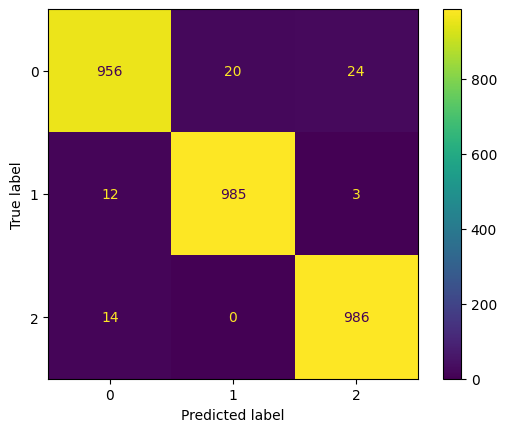


Test Accuracy: 0.9757


Test specificity Normal: 0.9870

Test specificity Covid: 0.9900

Test specificity Pnuemonia : 0.9865


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(testY, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

##specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

specificity_normal = (cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2])/((cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2]) + (cm[1,0] + cm[2,0]))
specificity_covid = (cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0] )/((cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0]) + (cm[0,1] + cm[2,1]))
specificity_pnuemonia = (cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])/((cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1]) + (cm[0,2] + cm[1,2]))
### Specificity = TN/TN + FP

####TN of C1" is all non-C1 instances that are not classified as C1.
#### "FP of C1" is all non-C1 instances that are classified as C1.

# show the confusion matrix, accuracy, sensitivity, and specificity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nTest Accuracy: {:.4f}\n'.format(accuracy_score(testY, y_pred)))
#print('\nTest Precision score:{:.4f}\n', precision_score(testY, y_pred, average=None))
##print('\nTest Recall score:{:.4f}\n', recall_score(testY, y_pred, average=None))
print('\nTest specificity Normal: {:.4f}'.format(specificity_normal))
print('\nTest specificity Covid: {:.4f}'.format(specificity_covid))
print('\nTest specificity Pnuemonia : {:.4f}'.format(specificity_pnuemonia))
#print('\nTest F1 score:{:.4f}\n' ,f1_score(testY, y_pred, average=None))


####Experiment 9 -  VGG19, SGD, Added dropout= 0.25 before Dense layer of 512.   Dropout = 0.5 after dense layer of 512, Additional dense layer of 128, Dropout=0.25 after dense layer of 128, Batchnormalization, learning_rate = 1e-2, decay_rate = 0.001, steps_per_epoch = 10000, epoch = 100, EarlyStopping

In [ ]:
from keras.applications.vgg19 import VGG19 ## pretrained model

base_model10= VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

model10 = Sequential()
model10.add(base_model10)

for layer in model10.layers:
    layer.trainable = False


model10.add(keras.layers.Flatten(input_shape=(224,224,3)))
model10.add(Dropout(0.25))
model10.add(Dense(512,activation='relu'))
model10.add(BatchNormalization())
model10.add(Dropout(0.5))
model10.add(Dense(128,activation='relu'))
model10.add(Dropout(0.25))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

model10.add(tf.keras.layers.Dense(3, activation = 'softmax'))

KeyboardInterrupt: ignored

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-2
##final_learning_rate = 0.00001
learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


callbacks = [EarlyStopping(monitor='val_loss', patience=10,  restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model10.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model10.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               12845568  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                      

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = model10.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 14s 44ms/step - loss: 0.4212 - accuracy: 0.8400 - val_loss: 0.1960 - val_accuracy: 0.9271
Epoch 2/100
300/300 [==============================] - 11s 35ms/step - loss: 0.2791 - accuracy: 0.8969 - val_loss: 0.1692 - val_accuracy: 0.9383
Epoch 3/100
300/300 [==============================] - 11s 35ms/step - loss: 0.2325 - accuracy: 0.9169 - val_loss: 0.1461 - val_accuracy: 0.9471
Epoch 4/100
300/300 [==============================] - 11s 35ms/step - loss: 0.2130 - accuracy: 0.9208 - val_loss: 0.1295 - val_accuracy: 0.9550
Epoch 5/100
300/300 [==============================] - 10s 34ms/step - loss: 0.1970 - accuracy: 0.9270 - val_loss: 0.1402 - val_accuracy: 0.9471
Epoch 6/100
300/300 [==============================] - 11s 35ms/step - loss: 0.1902 - accuracy: 0.9296 - val_loss: 0.1266 - val_accuracy: 0.9504
Epoch 7/100
300/300 [==============================] - 11s 35ms/step - loss: 0.1836 - accuracy: 0.9316 - val_loss: 0.1225 - val_ac

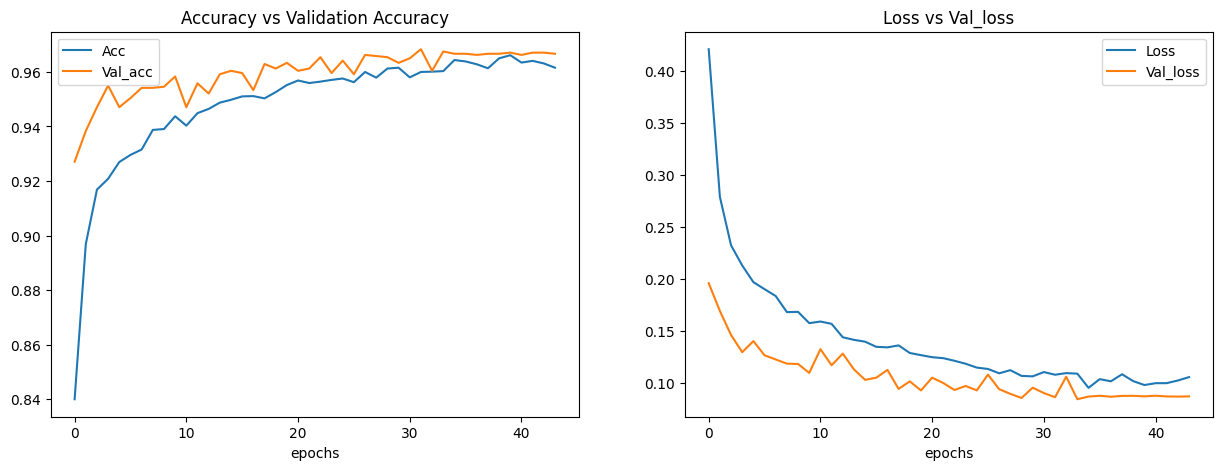

Training accuracy 0.9484013440934095
Validation accuracy 0.9595549174330451


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

#### Make Predictions against Test set

In [ ]:
# make predictions on the testing set
y_pred = model10.predict(testX, batch_size=32)
print(y_pred.shape  )
print(testY.shape)

94/94 [==============================] - 3s 25ms/step
(3000, 3)
(3000,)


(3000, 3)
(3000, 3)


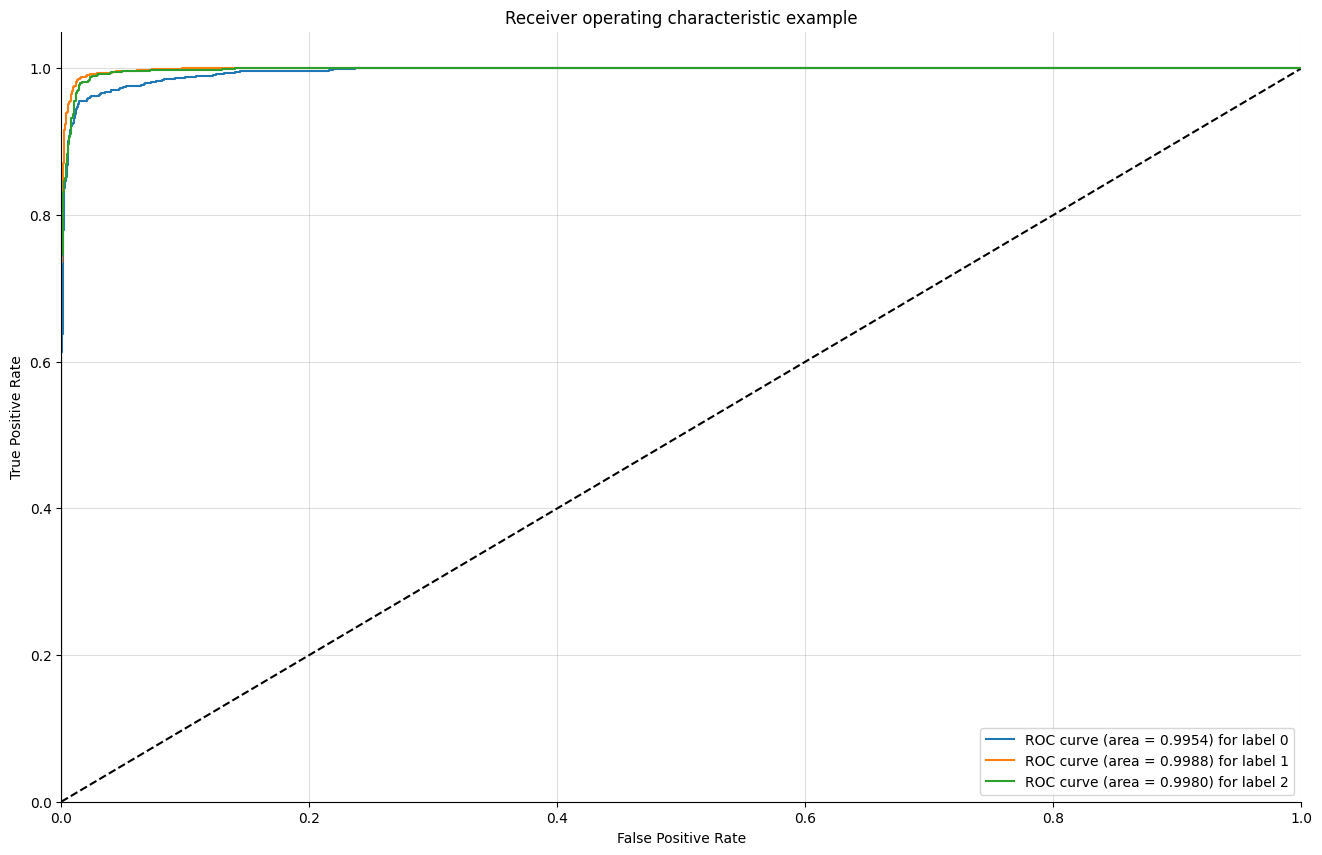

In [ ]:
from sklearn.preprocessing import label_binarize
def plot_multiclass_roc( testY, y_pred, n_classes, figsize=(12, 5)):


    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    ##y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    testY = label_binarize(testY, classes=[0,1,2])

    print(y_pred.shape)
    print(testY.shape)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(testY[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.4f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc( testY, y_pred, n_classes=3, figsize=(16, 10))

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape  )
print(testY.shape)

print(classification_report(testY, y_pred, target_names=['Normal', 'Covid', 'Pneumonia'], digits=4))


(3000,)
(3000,)
              precision    recall  f1-score   support

      Normal     0.9627    0.9560    0.9594      1000
       Covid     0.9761    0.9790    0.9775      1000
   Pneumonia     0.9701    0.9740    0.9721      1000

    accuracy                         0.9697      3000
   macro avg     0.9696    0.9697    0.9696      3000
weighted avg     0.9696    0.9697    0.9696      3000



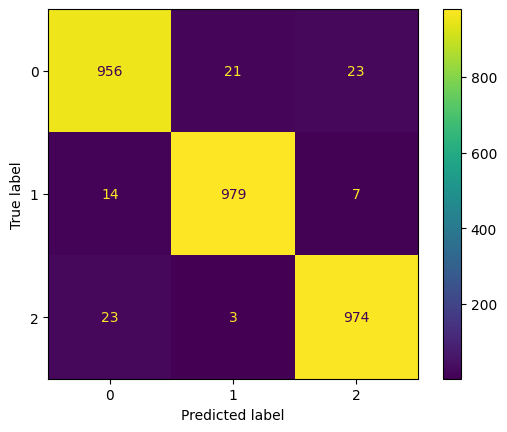


Test Accuracy: 0.9697


Test specificity Normal: 0.9815

Test specificity Covid: 0.9880

Test specificity Pnuemonia : 0.9850


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(testY, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

##specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

specificity_normal = (cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2])/((cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2]) + (cm[1,0] + cm[2,0]))
specificity_covid = (cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0] )/((cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0]) + (cm[0,1] + cm[2,1]))
specificity_pnuemonia = (cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])/((cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1]) + (cm[0,2] + cm[1,2]))
### Specificity = TN/TN + FP

####TN of C1" is all non-C1 instances that are not classified as C1.
#### "FP of C1" is all non-C1 instances that are classified as C1.

# show the confusion matrix, accuracy, sensitivity, and specificity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nTest Accuracy: {:.4f}\n'.format(accuracy_score(testY, y_pred)))
#print('\nTest Precision score:{:.4f}\n', precision_score(testY, y_pred, average=None))
##print('\nTest Recall score:{:.4f}\n', recall_score(testY, y_pred, average=None))
print('\nTest specificity Normal: {:.4f}'.format(specificity_normal))
print('\nTest specificity Covid: {:.4f}'.format(specificity_covid))
print('\nTest specificity Pnuemonia : {:.4f}'.format(specificity_pnuemonia))
#print('\nTest F1 score:{:.4f}\n' ,f1_score(testY, y_pred, average=None))


####Experiment 10 ## 8.05 - Reduced dropout=0.5 to 0.2

In [ ]:
from keras.applications.vgg19 import VGG19 ## pretrained model

base_model101= VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

model101 = Sequential()
model101.add(base_model101)

for layer in model101.layers:
    layer.trainable = False


model101.add(keras.layers.Flatten(input_shape=(224,224,3)))
#model101.add(Dropout(0.2))
model101.add(Dense(512,activation='relu'))
model101.add(BatchNormalization())
model101.add(Dropout(0.2))
model101.add(Dense(128,activation='relu'))
model101.add(Dropout(0.2))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

model101.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-2

learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


callbacks = [EarlyStopping(monitor='val_loss', patience=10,min_delta = 0.0001,  restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model101.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model101.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                        

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = model101.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 25s 47ms/step - loss: 0.2030 - accuracy: 0.9256 - val_loss: 0.2605 - val_accuracy: 0.9017
Epoch 2/100
300/300 [==============================] - 11s 36ms/step - loss: 0.1134 - accuracy: 0.9604 - val_loss: 0.1353 - val_accuracy: 0.9533
Epoch 3/100
300/300 [==============================] - 11s 37ms/step - loss: 0.0836 - accuracy: 0.9725 - val_loss: 0.1098 - val_accuracy: 0.9617
Epoch 4/100
300/300 [==============================] - 11s 36ms/step - loss: 0.0676 - accuracy: 0.9776 - val_loss: 0.0780 - val_accuracy: 0.9733
Epoch 5/100
300/300 [==============================] - 11s 36ms/step - loss: 0.0502 - accuracy: 0.9834 - val_loss: 0.0735 - val_accuracy: 0.9746
Epoch 6/100
300/300 [==============================] - 10s 35ms/step - loss: 0.0416 - accuracy: 0.9868 - val_loss: 0.0810 - val_accuracy: 0.9746
Epoch 7/100
300/300 [==============================] - 10s 35ms/step - loss: 0.0340 - accuracy: 0.9900 - val_loss: 0.1218 - val_ac

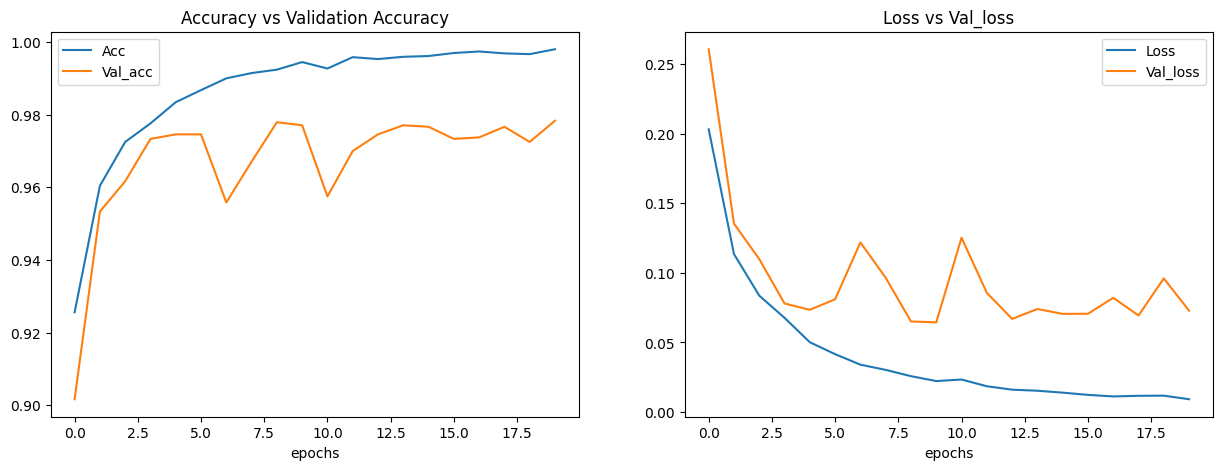

Training accuracy 0.986826753616333
Validation accuracy 0.9673750013113022


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

###Experiment 11 ## 8.06 - Reduced learning rate & decay factor rate

In [ ]:
from keras.applications.vgg19 import VGG19 ## pretrained model

base_model101= VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

model101 = Sequential()
model101.add(base_model101)

for layer in model101.layers:
    layer.trainable = False


model101.add(keras.layers.Flatten(input_shape=(224,224,3)))
#model101.add(Dropout(0.2))
model101.add(Dense(512,activation='relu'))
model101.add(BatchNormalization())
model101.add(Dropout(0.2))
model101.add(Dense(128,activation='relu'))
model101.add(Dropout(0.2))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

model101.add(tf.keras.layers.Dense(3, activation = 'softmax'))

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-3

learning_rate_decay_factor = 0.0001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


callbacks = [EarlyStopping(monitor='val_loss', patience=10,min_delta = 0.0001,  restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model101.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model101.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                        

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = model101.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 25s 46ms/step - loss: 0.3275 - accuracy: 0.8800 - val_loss: 0.2113 - val_accuracy: 0.9417
Epoch 2/100
300/300 [==============================] - 11s 36ms/step - loss: 0.2021 - accuracy: 0.9292 - val_loss: 0.1512 - val_accuracy: 0.9467
Epoch 3/100
300/300 [==============================] - 11s 36ms/step - loss: 0.1598 - accuracy: 0.9474 - val_loss: 0.1357 - val_accuracy: 0.9517
Epoch 4/100
300/300 [==============================] - 11s 36ms/step - loss: 0.1415 - accuracy: 0.9532 - val_loss: 0.1141 - val_accuracy: 0.9567
Epoch 5/100
300/300 [==============================] - 11s 36ms/step - loss: 0.1221 - accuracy: 0.9579 - val_loss: 0.1095 - val_accuracy: 0.9588
Epoch 6/100
300/300 [==============================] - 10s 35ms/step - loss: 0.1155 - accuracy: 0.9609 - val_loss: 0.1067 - val_accuracy: 0.9621
Epoch 7/100
300/300 [==============================] - 10s 35ms/step - loss: 0.1080 - accuracy: 0.9628 - val_loss: 0.0972 - val_ac

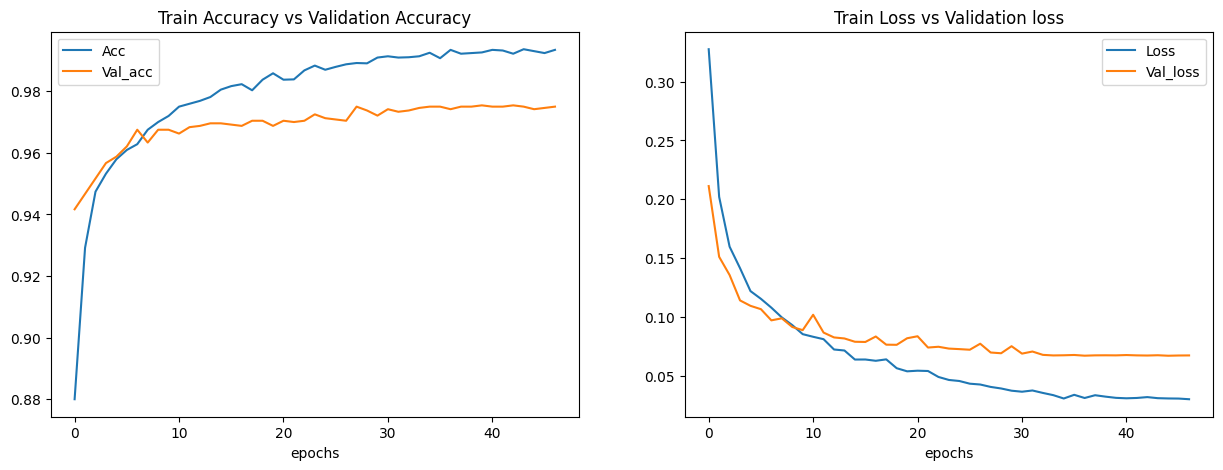

Training accuracy 0.9797141995835812
Validation accuracy 0.9693528413772583


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Train Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Train Loss vs Validation Loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

#### Make Predictions against Test set

In [ ]:
# make predictions on the testing set
y_pred = model101.predict(testX, batch_size=32)
print(y_pred.shape  )
print(testY.shape)

94/94 [==============================] - 2s 25ms/step
(3000, 3)
(3000,)


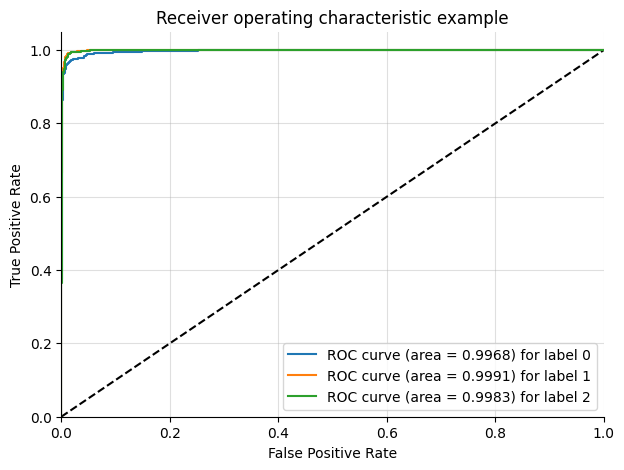

In [ ]:
from sklearn.preprocessing import label_binarize
def plot_multiclass_roc( testY, y_pred, n_classes, figsize=(12, 5)):


    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    ##y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    testY = label_binarize(testY, classes=[0,1,2])

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(testY[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.4f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc( testY, y_pred, n_classes=3, figsize=(7, 5))

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape  )
print(testY.shape)

print(classification_report(testY, y_pred, target_names=['Normal', 'Covid', 'Pneumonia'], digits=4))


(3000,)
(3000,)
              precision    recall  f1-score   support

      Normal     0.9776    0.9620    0.9698      1000
       Covid     0.9792    0.9880    0.9836      1000
   Pneumonia     0.9772    0.9840    0.9806      1000

    accuracy                         0.9780      3000
   macro avg     0.9780    0.9780    0.9780      3000
weighted avg     0.9780    0.9780    0.9780      3000



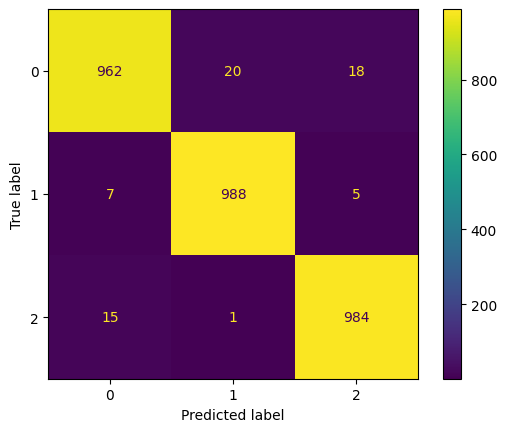


Test Accuracy: 0.9780


Test specificity Normal: 0.9890

Test specificity Covid: 0.9895

Test specificity Pnuemonia : 0.9885

Test specificity weighted average : 0.9880


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(testY, y_pred )

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Specificity = TN/TN + FP
####TN of C1" is all non-C1 instances that are not classified as C1.
#### "FP of C1" is all non-C1 instances that are classified as C1
specificity_normal = (cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2])/((cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2]) + (cm[1,0] + cm[2,0]))
specificity_covid = (cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0] )/((cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0]) + (cm[0,1] + cm[2,1]))
specificity_pnuemonia = (cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])/((cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1]) + (cm[0,2] + cm[1,2]))

specificity_weighted = (0.333 * specificity_normal) + (0.333 * specificity_covid) + (0.333 * specificity_pnuemonia)

# show the confusion matrix, accuracy, sensitivity, and specificity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nTest Accuracy: {:.4f}\n'.format(accuracy_score(testY, y_pred)))
print('\nTest specificity Normal: {:.4f}'.format(specificity_normal))
print('\nTest specificity Covid: {:.4f}'.format(specificity_covid))
print('\nTest specificity Pnuemonia : {:.4f}'.format(specificity_pnuemonia))
print('\nTest specificity weighted average : {:.4f}'.format(specificity_weighted))



### Experiment 8.1 Without EarlyStopping ; VGG19, SGD, Added dropout= 0.25 before Dense layer of 512.   Dropout = 0.5 after dense layer of 512, Additional dense layer of 128, Dropout=0.25 after dense layer of 128, Batchnormalization, learning_rate = 1e-2, decay_rate = 0.001, steps_per_epoch = 10000, epoch = 100

In [ ]:
epochs = 100
history = model10.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32
  ##callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 12s 41ms/step - loss: 0.1044 - accuracy: 0.9619 - val_loss: 0.0865 - val_accuracy: 0.9667
Epoch 2/100
300/300 [==============================] - 10s 34ms/step - loss: 0.1033 - accuracy: 0.9622 - val_loss: 0.0862 - val_accuracy: 0.9658
Epoch 3/100
300/300 [==============================] - 10s 34ms/step - loss: 0.0996 - accuracy: 0.9650 - val_loss: 0.0860 - val_accuracy: 0.9671
Epoch 4/100
300/300 [==============================] - 10s 34ms/step - loss: 0.1006 - accuracy: 0.9633 - val_loss: 0.0861 - val_accuracy: 0.9671
Epoch 5/100
300/300 [==============================] - 10s 34ms/step - loss: 0.0984 - accuracy: 0.9635 - val_loss: 0.0862 - val_accuracy: 0.9675
Epoch 6/100
300/300 [==============================] - 10s 34ms/step - loss: 0.1007 - accuracy: 0.9630 - val_loss: 0.0858 - val_accuracy: 0.9667
Epoch 7/100
300/300 [==============================] - 10s 34ms/step - loss: 0.1054 - accuracy: 0.9618 - val_loss: 0.0854 - val_ac

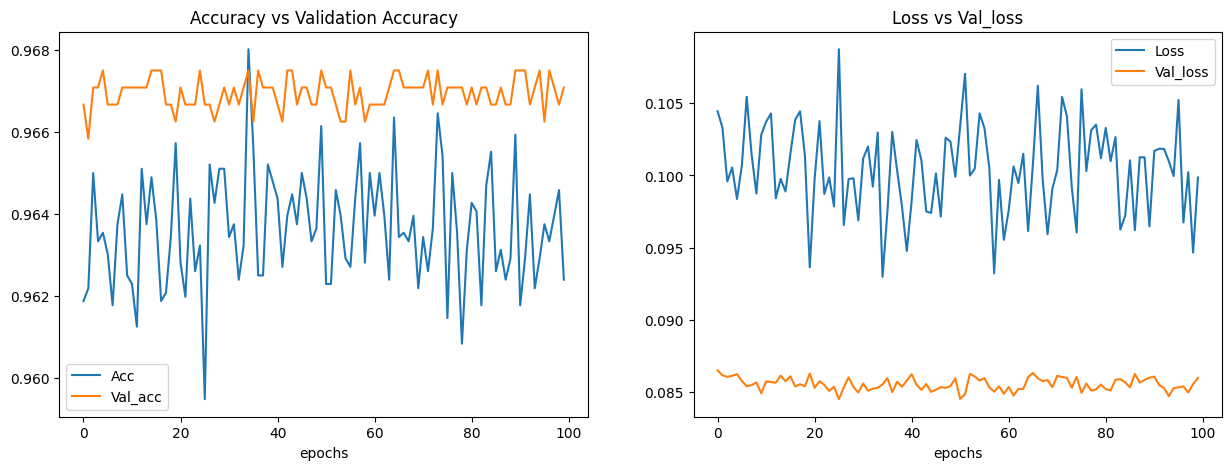

Training accuracy 0.9636264175176621
Validation accuracy 0.9669458186626434


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

####Experiment 12 -  VGG19, SGD, Added dropout= 0.25 before Dense layer of 512, Dropout = 0.5 after dense layer of 512, Additional dense layer of 128, Dropout=0.25 after dense layer of 128, learning_rate = 1e-2, decay_rate = 0.001, steps_per_epoch = 10000, epoch = 100, EarlyStopping

In [ ]:
from keras.applications.vgg19 import VGG19 ## pretrained model

base_model11= VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

model11 = Sequential()
model11.add(base_model11)

for layer in model11.layers:
    layer.trainable = False


model11.add(keras.layers.Flatten(input_shape=(224,224,3)))
model11.add(Dropout(0.25))
model11.add(Dense(512,activation='relu'))
## model10.add(BatchNormalization())         ## Removed Batchnormalization
model11.add(Dropout(0.5))
model11.add(Dense(128,activation='relu'))
model11.add(Dropout(0.25))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

model11.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-2
##final_learning_rate = 0.00001
learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

callbacks = [EarlyStopping(monitor='val_loss', patience=10),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model11.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = model11.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 13s 41ms/step - loss: 0.8592 - accuracy: 0.6127 - val_loss: 0.4235 - val_accuracy: 0.8717
Epoch 2/100
300/300 [==============================] - 10s 34ms/step - loss: 0.4957 - accuracy: 0.8066 - val_loss: 0.3036 - val_accuracy: 0.8929
Epoch 3/100
300/300 [==============================] - 10s 34ms/step - loss: 0.4029 - accuracy: 0.8480 - val_loss: 0.2566 - val_accuracy: 0.9100
Epoch 4/100
300/300 [==============================] - 10s 34ms/step - loss: 0.3427 - accuracy: 0.8749 - val_loss: 0.2216 - val_accuracy: 0.9237
Epoch 5/100
300/300 [==============================] - 10s 35ms/step - loss: 0.3074 - accuracy: 0.8846 - val_loss: 0.2000 - val_accuracy: 0.9283
Epoch 6/100
300/300 [==============================] - 10s 33ms/step - loss: 0.2923 - accuracy: 0.8939 - val_loss: 0.2188 - val_accuracy: 0.9125
Epoch 7/100
300/300 [==============================] - 10s 34ms/step - loss: 0.2788 - accuracy: 0.8992 - val_loss: 0.1948 - val_ac

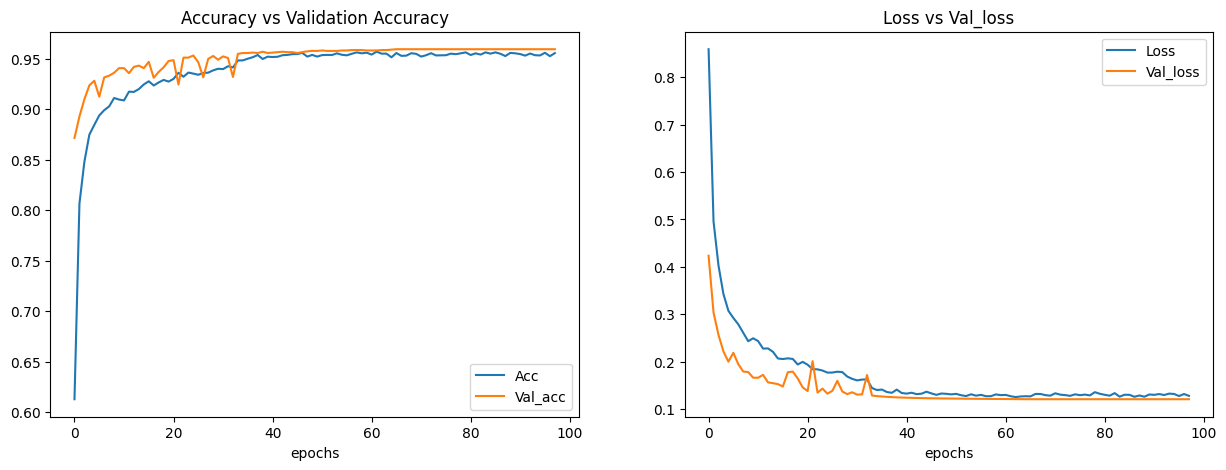

Training accuracy 0.9383800613636873
Validation accuracy 0.9508971097517986


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

#### Make Predictions against Test set

In [ ]:
# make predictions on the Test set
print("[INFO] evaluating network...")
print( len(testX))

y_pred = model11.predict(testX, batch_size=32)
print(y_pred.shape  )
print(testY.shape)

y_pred = np.argmax(y_pred, axis=1)

print(classification_report(testY, y_pred, target_names=['Normal', 'Covid', 'Pneumonia'], digits=4))

[INFO] evaluating network...
3000
94/94 [==============================] - 2s 24ms/step
(3000, 3)
(3000,)
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1000
           1       0.96      0.98      0.97      1000
           2       0.97      0.96      0.96      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000

              precision    recall  f1-score   support

      Normal       0.95      0.94      0.94      1000
       Covid       0.96      0.98      0.97      1000
   Pneumonia       0.97      0.96      0.96      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



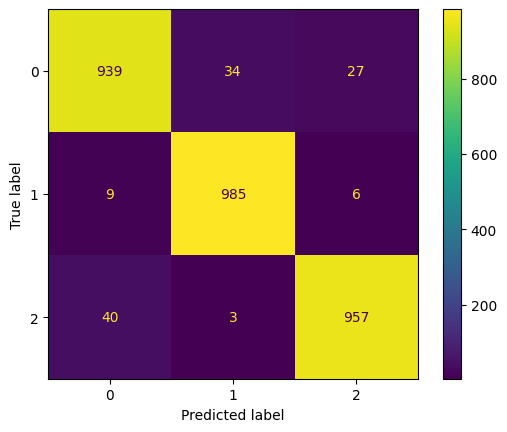


Test Accuracy: 0.96


Test Precision score: [0.95040486 0.96379648 0.96666667]

Test Recall score: [0.939 0.985 0.957]

Test F1 score: [0.94466801 0.97428289 0.96180905]


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(testY, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nTest Accuracy: {:.4f}\n'.format(accuracy_score(testY, y_pred)))
print('\nTest Precision score:{:.4f}\n', precision_score(testY, y_pred, average=None))
print('\nTest Recall score:{:.4f}\n', recall_score(testY, y_pred, average=None))
print('\nTest specificity: {:.4f}'.format(specificity))
print('\nTest F1 score:{:.4f}\n' ,f1_score(testY, y_pred, average=None))



####Experiment 10 -VGG19, SGD, Added dropout= 0.25 before Dense layer of 512.   Dropout = 0.5 after dense layer of 512, Additional dense layer of 128, Dropout=0.25 after dense layer of 128, Batchnormalization, learning_rate = 1e-2, decay_rate = 0.001, steps_per_epoch = int(len(trainX)/batch_size), epoch = 100, EarlyStopping

In [ ]:
from keras.applications.vgg19 import VGG19 ## pretrained model

base_model12= VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

model12 = Sequential()
model12.add(base_model12)

for layer in model12.layers:
    layer.trainable = False


model12.add(keras.layers.Flatten(input_shape=(224,224,3)))
model12.add(Dropout(0.25))
model12.add(Dense(512,activation='relu'))
model12.add(BatchNormalization())
model12.add(Dropout(0.5))
model12.add(Dense(128,activation='relu'))
model12.add(Dropout(0.25))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

model12.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-2

learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(len(trainX)/batch_size)  ## Changed the steps_per_epoch from 10000 to formula

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


callbacks = [EarlyStopping(monitor='val_loss', patience=10),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model12.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model12.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_6 (Dropout)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                      

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = model12.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 13s 41ms/step - loss: 0.4169 - accuracy: 0.8390 - val_loss: 0.1907 - val_accuracy: 0.9317
Epoch 2/100
300/300 [==============================] - 11s 35ms/step - loss: 0.2988 - accuracy: 0.8918 - val_loss: 0.1734 - val_accuracy: 0.9354
Epoch 3/100
300/300 [==============================] - 10s 34ms/step - loss: 0.2905 - accuracy: 0.8916 - val_loss: 0.1746 - val_accuracy: 0.9362
Epoch 4/100
300/300 [==============================] - 10s 34ms/step - loss: 0.3030 - accuracy: 0.8924 - val_loss: 0.1743 - val_accuracy: 0.9362
Epoch 5/100
300/300 [==============================] - 10s 34ms/step - loss: 0.2860 - accuracy: 0.8935 - val_loss: 0.1748 - val_accuracy: 0.9362
Epoch 6/100
300/300 [==============================] - 10s 34ms/step - loss: 0.2928 - accuracy: 0.8921 - val_loss: 0.1748 - val_accuracy: 0.9358
Epoch 7/100
300/300 [==============================] - 10s 34ms/step - loss: 0.2893 - accuracy: 0.8925 - val_loss: 0.1743 - val_ac

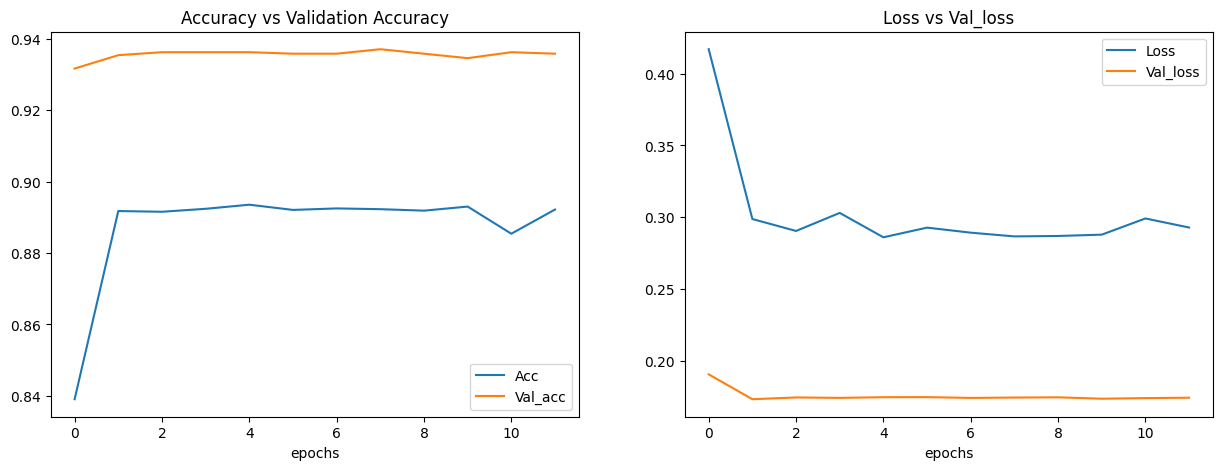

Training accuracy 0.8872972875833511
Validation accuracy 0.9355902622143427


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

#### Make Predictions against Test set

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
print( len(testX))

y_pred = model12.predict(testX, batch_size=32)
print(y_pred.shape  )
print(testY.shape)

y_pred = np.argmax(y_pred, axis=1)


print(classification_report(testY, y_pred, target_names=['Normal', 'Covid', 'Pneumonia'], digits=4))

[INFO] evaluating network...
3000
94/94 [==============================] - 2s 25ms/step
(3000, 3)
(3000,)
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1000
           1       0.94      0.96      0.95      1000
           2       0.96      0.93      0.94      1000

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000

              precision    recall  f1-score   support

      Normal       0.91      0.91      0.91      1000
       Covid       0.94      0.96      0.95      1000
   Pneumonia       0.96      0.93      0.94      1000

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



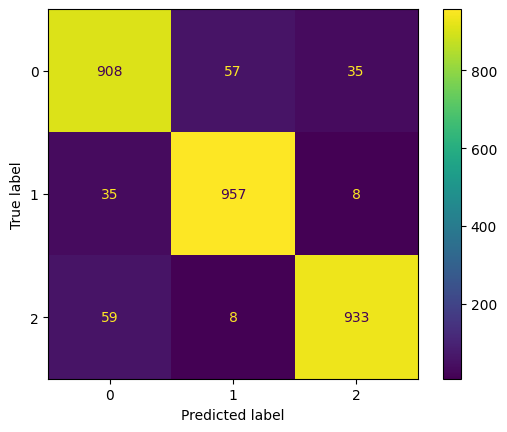


Test Accuracy: 0.93


Test Precision score:["Normal"] ["Covid"] ["Pnuemonia"] [0.90618762 0.93639922 0.95594262]

Test Recall score: [0.908 0.957 0.933]

Test F1 score: [0.90709291 0.94658754 0.94433198]


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(testY, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nTest Accuracy: {:.4f}\n'.format(accuracy_score(testY, y_pred)))
print('\nTest Precision score:{:.4f}\n', precision_score(testY, y_pred, average=None))
print('\nTest Recall score:{:.4f}\n', recall_score(testY, y_pred, average=None))
print('\nTest specificity: {:.4f}'.format(specificity))
print('\nTest F1 score:{:.4f}\n' ,f1_score(testY, y_pred, average=None))


#### Experiment 14: VGG19, SGD, Added dropout= 0.25 before Dense layer of 512.   Dropout = 0.5 after dense layer of 512, Additional dense layer of 128, Dropout=0.25 after dense layer of 128, Batchnormalization, learning_rate = 1e-2, decay_rate = learning_rate / epochs , steps_per_epoch = 10000, epoch = 100, EarlyStopping

In [ ]:
from keras.applications.vgg19 import VGG19 ## pretrained model

base_model13= VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

model13 = Sequential()
model13.add(base_model13)

for layer in model13.layers:
    layer.trainable = False

model13.add(keras.layers.Flatten(input_shape=(224,224,3)))
model13.add(Dropout(0.25))
model13.add(Dense(512,activation='relu'))
model13.add(BatchNormalization())
model13.add(Dropout(0.5))
model13.add(Dense(128,activation='relu'))
model13.add(Dropout(0.25))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

model13.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

epochs = 100

initial_learning_rate =  1e-2

##learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)
learning_rate_decay_factor = initial_learning_rate / epochs           ## Change in learning rate decay factor from 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


callbacks = [EarlyStopping(monitor='val_loss', patience=10),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model13.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model13.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_9 (Dropout)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               12845568  
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                      

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = model13.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 15s 41ms/step - loss: 0.4224 - accuracy: 0.8460 - val_loss: 0.1995 - val_accuracy: 0.9217
Epoch 2/100
300/300 [==============================] - 11s 35ms/step - loss: 0.2852 - accuracy: 0.8942 - val_loss: 0.1590 - val_accuracy: 0.9442
Epoch 3/100
300/300 [==============================] - 10s 34ms/step - loss: 0.2389 - accuracy: 0.9142 - val_loss: 0.1591 - val_accuracy: 0.9421
Epoch 4/100
300/300 [==============================] - 11s 35ms/step - loss: 0.2163 - accuracy: 0.9222 - val_loss: 0.1323 - val_accuracy: 0.9550
Epoch 5/100
300/300 [==============================] - 10s 34ms/step - loss: 0.2027 - accuracy: 0.9259 - val_loss: 0.1733 - val_accuracy: 0.9367
Epoch 6/100
300/300 [==============================] - 10s 35ms/step - loss: 0.1931 - accuracy: 0.9298 - val_loss: 0.1293 - val_accuracy: 0.9538
Epoch 7/100
300/300 [==============================] - 10s 34ms/step - loss: 0.1810 - accuracy: 0.9325 - val_loss: 0.1347 - val_ac

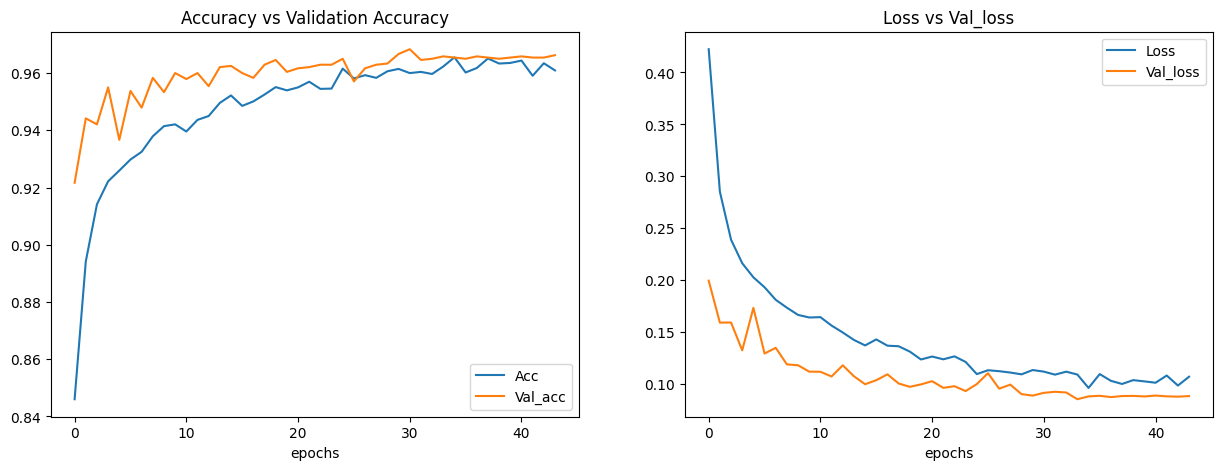

Training accuracy 0.9483255825259469
Validation accuracy 0.9595927961847999


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

#### Make Predictions against Test set

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
print( len(testX))

y_pred = model13.predict(testX, batch_size=32)
print(y_pred.shape  )
print(testY.shape)

y_pred = np.argmax(y_pred, axis=1)


print(classification_report(testY, y_pred, target_names=['Normal', 'Covid', 'Pneumonia'], digits=4))

[INFO] evaluating network...
3000
94/94 [==============================] - 2s 24ms/step
(3000, 3)
(3000,)
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1000
           1       0.98      0.98      0.98      1000
           2       0.97      0.97      0.97      1000

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000

              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96      1000
       Covid       0.98      0.98      0.98      1000
   Pneumonia       0.97      0.97      0.97      1000

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



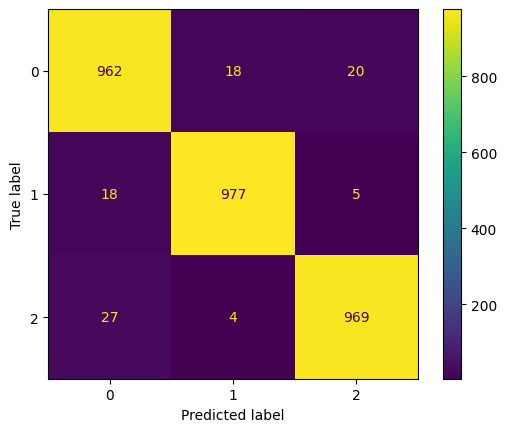


Test Accuracy: 0.97


Test Precision score:["Normal"] ["Covid"] ["Pnuemonia"] [0.95531281 0.97797798 0.97484909]

Test Recall score: [0.962 0.977 0.969]

Test F1 score: [0.95864474 0.97748874 0.97191575]


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(testY, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nTest Accuracy: {:.4f}\n'.format(accuracy_score(testY, y_pred)))
print('\nTest Precision score:{:.4f}\n', precision_score(testY, y_pred, average=None))
print('\nTest Recall score:{:.4f}\n', recall_score(testY, y_pred, average=None))
print('\nTest specificity: {:.4f}'.format(specificity))
print('\nTest F1 score:{:.4f}\n' ,f1_score(testY, y_pred, average=None))


In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds= roc_curve(testY, y_pred, pos_label=3, sample_weight=None)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


### Experiment 15- Exp 10  With callback and dropout from 0.25 to 0.5
### VGG19, SGD, Added dropout= 0.25 before Dense layer of 512.   Dropout = 0.5 after dense layer of 512, Additional dense layer of 128, Dropout=0.5 after dense layer of 128, Batchnormalization, learning_rate = 1e-2, decay_rate = 0.001, steps_per_epoch = 10000, epoch = 100, EarlyStopping

In [ ]:
from keras.applications.vgg19 import VGG19 ## pretrained model

base_model14= VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

model14 = Sequential()
model14.add(base_model14)

for layer in model14.layers:
    layer.trainable = False


model14.add(keras.layers.Flatten(input_shape=(224,224,3)))
model14.add(Dropout(0.25))
model14.add(Dense(512,activation='relu'))
model14.add(BatchNormalization())
model14.add(Dropout(0.5))
model14.add(Dense(128,activation='relu'))
model14.add(Dropout(0.5))       ## Changed from 0.25 to 0.5

## Final Dense layer with activation fumction = 'softmax' ( for classification)

model14.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:

initial_learning_rate =  1e-2
##final_learning_rate = 0.00001
learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

## Pateince changed to 8
callbacks = [EarlyStopping(monitor='val_loss', patience=10, mode= "min", restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model14.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model14.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               12845568  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                      

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = model14.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 15s 43ms/step - loss: 0.5092 - accuracy: 0.8149 - val_loss: 0.1928 - val_accuracy: 0.9262
Epoch 2/100
300/300 [==============================] - 11s 35ms/step - loss: 0.3178 - accuracy: 0.8825 - val_loss: 0.1663 - val_accuracy: 0.9396
Epoch 3/100
300/300 [==============================] - 10s 34ms/step - loss: 0.2591 - accuracy: 0.9042 - val_loss: 0.1722 - val_accuracy: 0.9367
Epoch 4/100
300/300 [==============================] - 11s 35ms/step - loss: 0.2423 - accuracy: 0.9123 - val_loss: 0.1510 - val_accuracy: 0.9492
Epoch 5/100
300/300 [==============================] - 10s 34ms/step - loss: 0.2213 - accuracy: 0.9152 - val_loss: 0.1972 - val_accuracy: 0.9212
Epoch 6/100
300/300 [==============================] - 11s 35ms/step - loss: 0.2062 - accuracy: 0.9234 - val_loss: 0.1387 - val_accuracy: 0.9500
Epoch 7/100
300/300 [==============================] - 10s 34ms/step - loss: 0.2005 - accuracy: 0.9268 - val_loss: 0.1481 - val_ac

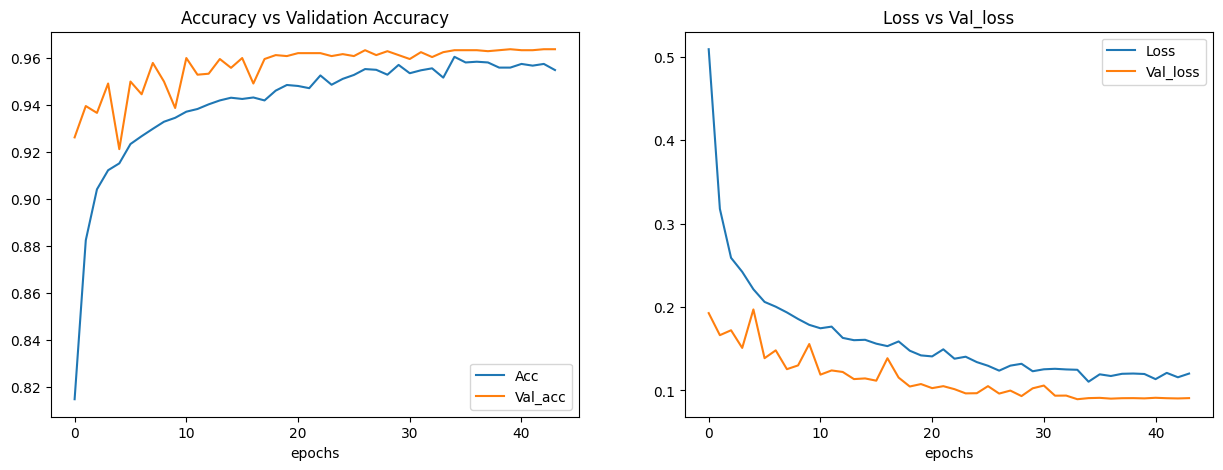

Training accuracy 0.9411373328078877
Validation accuracy 0.9564583274451169


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

### Experiment 16- VGG19, SGD, Added dropout= 0.25 before Dense layer of 512.   Dropout = 0.5 after dense layer of 512, Dense layer 128 changed to 512, Dropout=0.5 after dense layer of 512, Batchnormalization, learning_rate = 1e-2, decay_rate = 0.001, steps_per_epoch = 10000, epoch = 100, EarlyStopping

In [ ]:
from keras.applications.vgg19 import VGG19 ## pretrained model

base_model15= VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

model15 = Sequential()
model15.add(base_model15)

for layer in model15.layers:
    layer.trainable = False


model15.add(keras.layers.Flatten(input_shape=(224,224,3)))
model15.add(Dropout(0.25))
model15.add(Dense(512,activation='relu'))
model15.add(BatchNormalization())
model15.add(Dropout(0.5))
model15.add(Dense(512,activation='relu'))        ## Changed from 128 to 512
model15.add(Dropout(0.25))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

model15.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

initial_learning_rate =  1e-2

learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


callbacks = [EarlyStopping(monitor='val_loss', patience=10, mode= "min", restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model15.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model15.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_6 (Dropout)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                      

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = model15.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 14s 41ms/step - loss: 0.4043 - accuracy: 0.8459 - val_loss: 0.2136 - val_accuracy: 0.9233
Epoch 2/100
300/300 [==============================] - 11s 36ms/step - loss: 0.2706 - accuracy: 0.8963 - val_loss: 0.1792 - val_accuracy: 0.9321
Epoch 3/100
300/300 [==============================] - 11s 35ms/step - loss: 0.2251 - accuracy: 0.9195 - val_loss: 0.1578 - val_accuracy: 0.9429
Epoch 4/100
300/300 [==============================] - 11s 36ms/step - loss: 0.2169 - accuracy: 0.9202 - val_loss: 0.1471 - val_accuracy: 0.9458
Epoch 5/100
300/300 [==============================] - 10s 34ms/step - loss: 0.2013 - accuracy: 0.9229 - val_loss: 0.1855 - val_accuracy: 0.9279
Epoch 6/100
300/300 [==============================] - 11s 35ms/step - loss: 0.1968 - accuracy: 0.9232 - val_loss: 0.1182 - val_accuracy: 0.9600
Epoch 7/100
300/300 [==============================] - 10s 34ms/step - loss: 0.1775 - accuracy: 0.9358 - val_loss: 0.1382 - val_ac

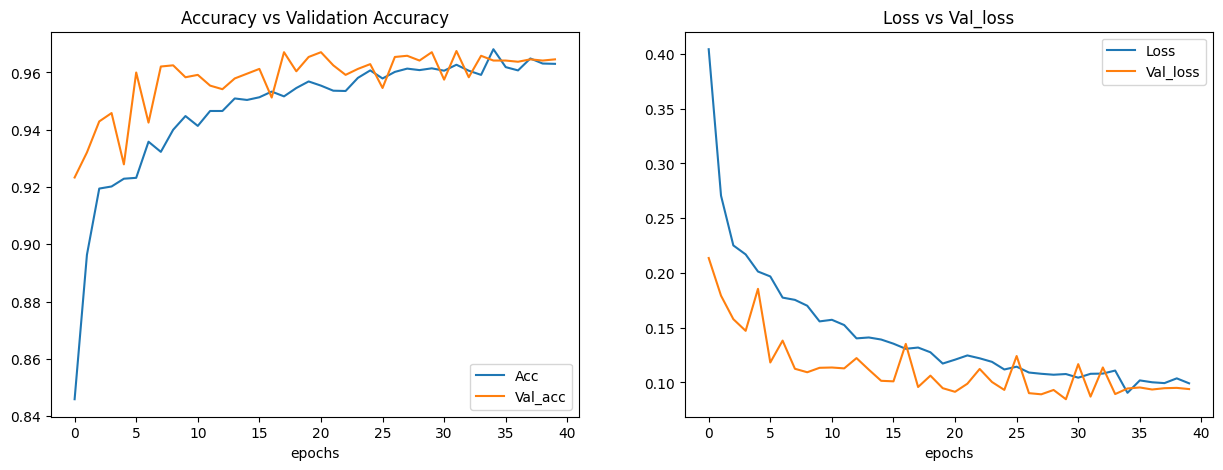

Training accuracy 0.9473148226737976
Validation accuracy 0.9578437432646751


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

###Experiment R1: RESNET 50 ,Dense 128, SGD

In [ ]:
from tensorflow.keras.applications import ResNet50

base_modelr1= ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

modelr1 = Sequential()
modelr1.add(base_modelr1)

for layer in modelr1.layers:
    layer.trainable = False


modelr1.add(keras.layers.Flatten(input_shape=(224,224,3)))
##modelr1.add(Dropout(0.25))
modelr1.add(Dense(128,activation='relu'))
##modelr1.add(Dropout(0.25))


## Final Dense layer with activation fumction = 'softmax' ( for classification)

modelr1.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded

initial_learning_rate =  1e-2

learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


callbacks = [EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.0001, restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

modelr1.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelr1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               12845184  
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 36,433,283
Trainable params: 12,845,571
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
epochs = 100

history = modelr1.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 23s 39ms/step - loss: 2.6783 - accuracy: 0.3333 - val_loss: 1.0989 - val_accuracy: 0.3154
Epoch 2/100
300/300 [==============================] - 7s 25ms/step - loss: 1.0987 - accuracy: 0.3332 - val_loss: 1.0991 - val_accuracy: 0.3154
Epoch 3/100
300/300 [==============================] - 7s 25ms/step - loss: 1.0987 - accuracy: 0.3378 - val_loss: 1.0991 - val_accuracy: 0.3154
Epoch 4/100
300/300 [==============================] - 7s 24ms/step - loss: 1.0987 - accuracy: 0.3378 - val_loss: 1.0991 - val_accuracy: 0.3154
Epoch 5/100
300/300 [==============================] - 7s 24ms/step - loss: 1.0987 - accuracy: 0.3376 - val_loss: 1.0991 - val_accuracy: 0.3154
Epoch 6/100
300/300 [==============================] - 7s 24ms/step - loss: 1.0987 - accuracy: 0.3378 - val_loss: 1.0990 - val_accuracy: 0.3154
Epoch 7/100
300/300 [==============================] - 7s 24ms/step - loss: 1.0987 - accuracy: 0.3378 - val_loss: 1.0990 - val_accuracy

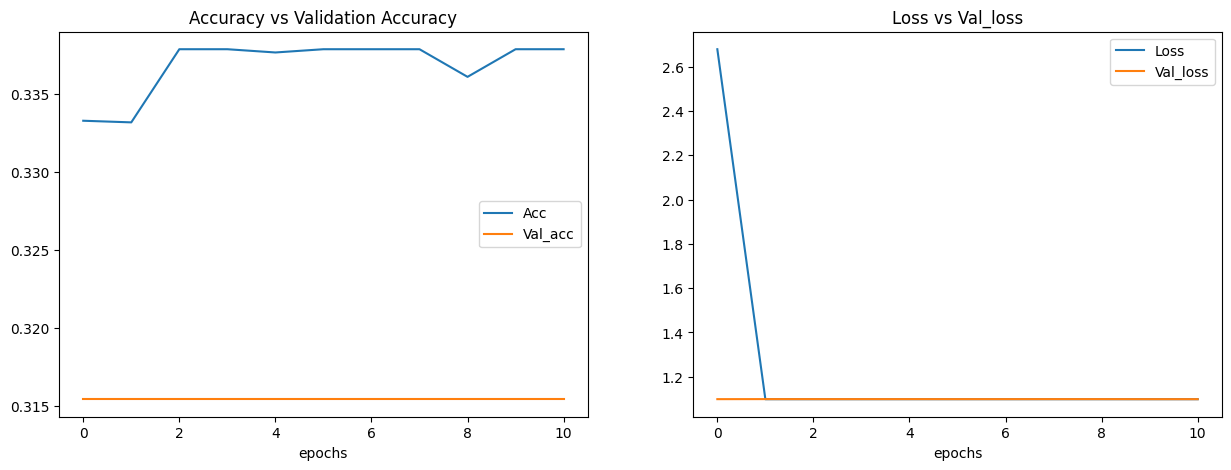

Training accuracy 0.33682485060258344
Validation accuracy 0.3154166638851166


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

###Experiment R2

In [ ]:
from tensorflow.keras.applications import ResNet50

base_modelr11= ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

modelr11 = Sequential()
modelr11.add(base_modelr11)

for layer in modelr11.layers:
    layer.trainable = False


modelr11.add(keras.layers.Flatten(input_shape=(224,224,3)))

modelr11.add(Dense(512,activation='relu'))
modelr11.add(Dropout(0.25))
modelr11.add(Dense(128,activation='relu'))
modelr11.add(Dropout(0.5))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

modelr11.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:

initial_learning_rate =  1e-2

learning_rate_decay_factor = 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

## Pateince changed to 8
callbacks = [EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.0001, restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

modelr11.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelr11.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_8 (Flatten)         (None, 100352)            0         
                                                                 
 dense_21 (Dense)            (None, 512)               51380736  
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               65664     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 3)                

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = modelr11.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 15s 40ms/step - loss: 1.4411 - accuracy: 0.3319 - val_loss: 1.0989 - val_accuracy: 0.3158
Epoch 2/100
300/300 [==============================] - 7s 24ms/step - loss: 1.0987 - accuracy: 0.3325 - val_loss: 1.0992 - val_accuracy: 0.3154
Epoch 3/100
300/300 [==============================] - 7s 24ms/step - loss: 1.0987 - accuracy: 0.3378 - val_loss: 1.0991 - val_accuracy: 0.3154
Epoch 4/100
300/300 [==============================] - 7s 24ms/step - loss: 1.0987 - accuracy: 0.3378 - val_loss: 1.0991 - val_accuracy: 0.3154
Epoch 5/100
300/300 [==============================] - 7s 25ms/step - loss: 1.0987 - accuracy: 0.3378 - val_loss: 1.0991 - val_accuracy: 0.3154
Epoch 6/100
300/300 [==============================] - 8s 25ms/step - loss: 1.0987 - accuracy: 0.3378 - val_loss: 1.0990 - val_accuracy: 0.3154
Epoch 7/100
300/300 [==============================] - 7s 25ms/step - loss: 1.0987 - accuracy: 0.3378 - val_loss: 1.0990 - val_accuracy

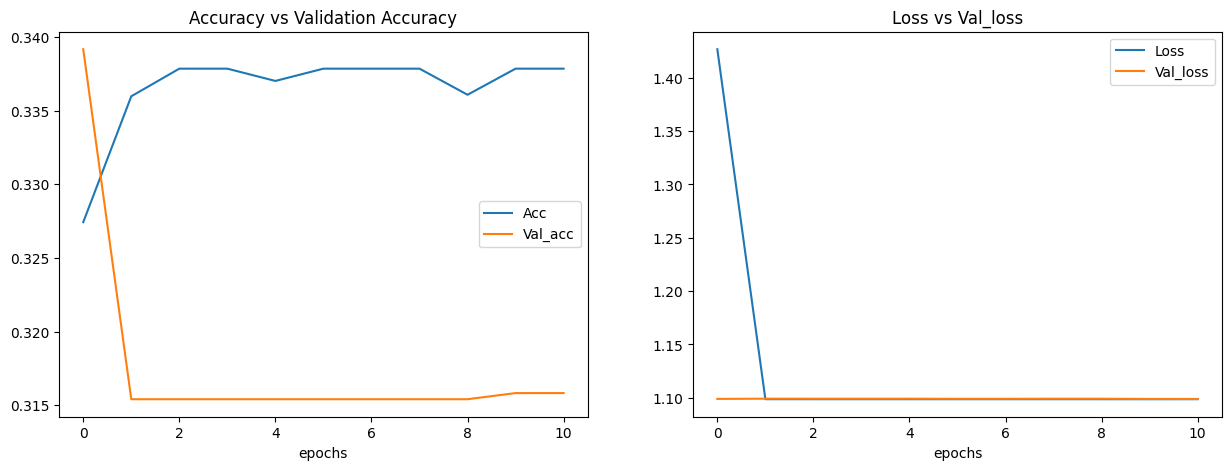

Training accuracy 0.33649337562647735
Validation accuracy 0.3176515129479495


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

###Experiment R3  learning rate 1e-3

In [ ]:
initial_learning_rate =  1e-3

learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

## Pateince changed to 8
callbacks = [EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.0001, restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

modelr11.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelr11.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_9 (Flatten)         (None, 100352)            0         
                                                                 
 dense_24 (Dense)            (None, 512)               51380736  
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               65664     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 3)                

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = modelr11.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

####Experiment R4 -  RESNET50, SGD, Added dropout= 0.25 before Dense layer of 512.   Dropout = 0.5 after dense layer of 512, Additional dense layer of 128, Dropout=0.25 after dense layer of 128, Batchnormalization, learning_rate = 1e-2, decay_rate = 0.001, steps_per_epoch = 10000, epoch = 100, EarlyStopping

In [ ]:
from tensorflow.keras.applications import ResNet50

base_modelr2= ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

modelr2 = Sequential()
modelr2.add(base_modelr2)

for layer in modelr2.layers:
    layer.trainable = False


modelr2.add(keras.layers.Flatten(input_shape=(224,224,3)))
modelr2.add(Dropout(0.25))
modelr2.add(Dense(512,activation='relu'))
modelr2.add(BatchNormalization())
#modelr2.add(Dropout(0.5))
modelr2.add(Dense(128,activation='relu'))
#modelr2.add(Dropout(0.25))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

modelr2.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-3

learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

## Pateince changed to 8
callbacks = [EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.0001, restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

modelr2.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelr2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 512)               51380736  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                      

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = modelr2.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 17s 46ms/step - loss: 0.9315 - accuracy: 0.5627 - val_loss: 1.1167 - val_accuracy: 0.3787
Epoch 2/100
300/300 [==============================] - 9s 30ms/step - loss: 0.7754 - accuracy: 0.6700 - val_loss: 0.8014 - val_accuracy: 0.6521
Epoch 3/100
300/300 [==============================] - 9s 30ms/step - loss: 0.7015 - accuracy: 0.7066 - val_loss: 0.5399 - val_accuracy: 0.8146
Epoch 4/100
300/300 [==============================] - 9s 30ms/step - loss: 0.6691 - accuracy: 0.7247 - val_loss: 0.5208 - val_accuracy: 0.8100
Epoch 5/100
300/300 [==============================] - 8s 26ms/step - loss: 0.6304 - accuracy: 0.7438 - val_loss: 0.5716 - val_accuracy: 0.7713
Epoch 6/100
300/300 [==============================] - 9s 29ms/step - loss: 0.5966 - accuracy: 0.7617 - val_loss: 0.4522 - val_accuracy: 0.8462
Epoch 7/100
300/300 [==============================] - 7s 25ms/step - loss: 0.5860 - accuracy: 0.7673 - val_loss: 0.5114 - val_accuracy

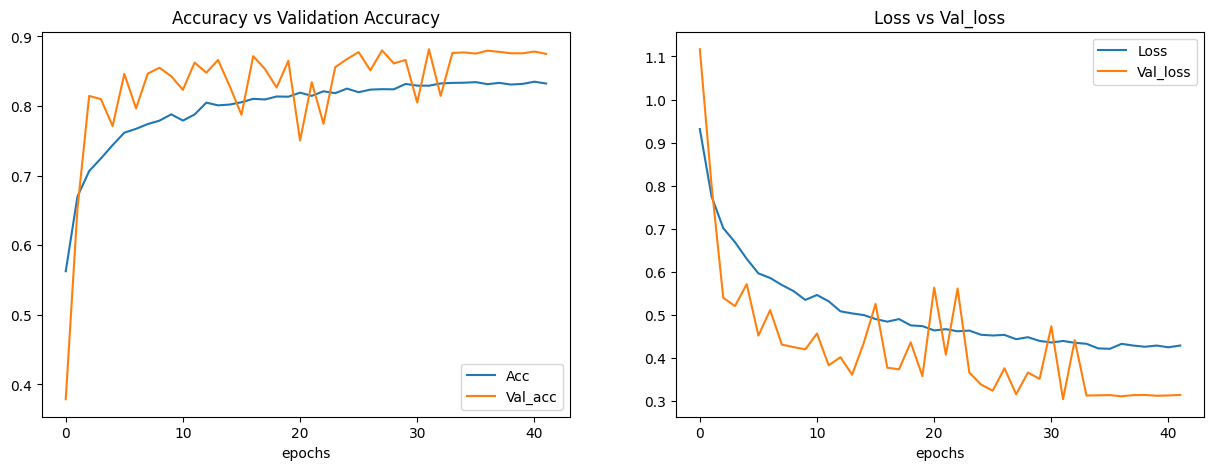

Training accuracy 0.7979799466473716
Validation accuracy 0.8299504028899329


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

### Experiment R5 -Reduce the dropout and decay rate

In [ ]:
from tensorflow.keras.applications import ResNet50

base_modelr21= ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

modelr21 = Sequential()
modelr21.add(base_modelr21)

for layer in modelr21.layers:
    layer.trainable = False


modelr21.add(keras.layers.Flatten(input_shape=(224,224,3)))

modelr21.add(Dense(512,activation='relu'))
modelr21.add(BatchNormalization())
#modelr21.add(Dropout(0.5))
modelr21.add(Dense(128,activation='relu'))
modelr21.add(Dropout(0.2))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

modelr21.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-3

learning_rate_decay_factor = 0.00001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


callbacks = [EarlyStopping(monitor='val_loss', patience=10,min_delta = 0.0001,  restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

modelr21.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelr21.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 512)               51380736  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                      

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = modelr21.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 16s 39ms/step - loss: 0.3371 - accuracy: 0.8750 - val_loss: 0.6815 - val_accuracy: 0.7575
Epoch 2/100
300/300 [==============================] - 9s 28ms/step - loss: 0.2411 - accuracy: 0.9110 - val_loss: 0.4578 - val_accuracy: 0.8129
Epoch 3/100
300/300 [==============================] - 7s 24ms/step - loss: 0.1992 - accuracy: 0.9298 - val_loss: 7.0222 - val_accuracy: 0.3229
Epoch 4/100
300/300 [==============================] - 7s 24ms/step - loss: 0.1777 - accuracy: 0.9390 - val_loss: 4.1576 - val_accuracy: 0.3738
Epoch 5/100
300/300 [==============================] - 9s 30ms/step - loss: 0.1658 - accuracy: 0.9427 - val_loss: 0.3736 - val_accuracy: 0.8512
Epoch 6/100
300/300 [==============================] - 7s 24ms/step - loss: 0.1529 - accuracy: 0.9479 - val_loss: 1.1818 - val_accuracy: 0.5550
Epoch 7/100
300/300 [==============================] - 7s 24ms/step - loss: 0.1469 - accuracy: 0.9490 - val_loss: 4.1144 - val_accuracy

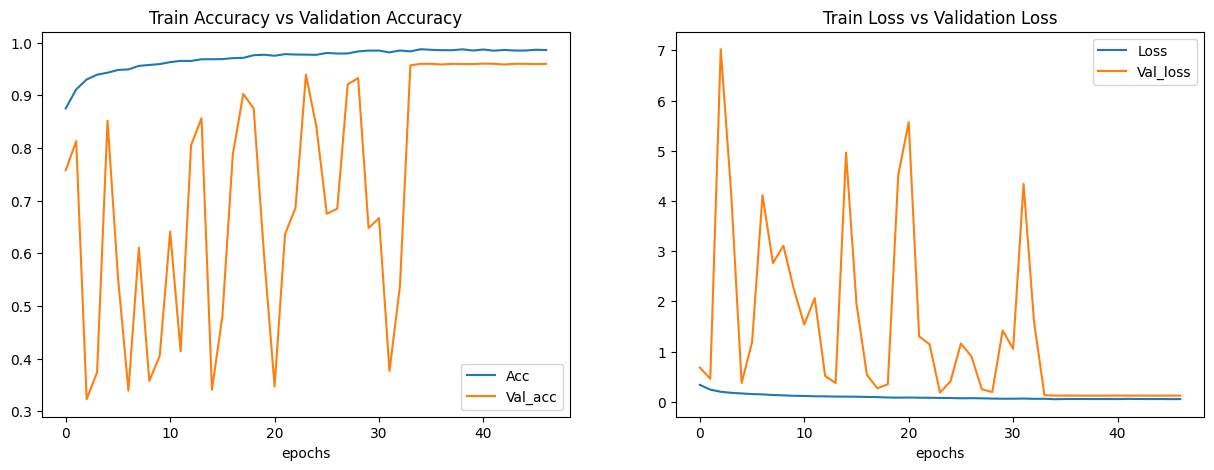

Training accuracy 0.9701653275083988
Validation accuracy 0.7319148905733799


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Train Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Train Loss vs Validation Loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

#### Make Predictions against Test set

In [ ]:
# make predictions on the testing set
y_pred = modelr21.predict(testX, batch_size=32)
print(y_pred.shape  )
print(testY.shape)

In [ ]:
from sklearn.preprocessing import label_binarize
def plot_multiclass_roc( testY, y_pred, n_classes, figsize=(17, 6)):


    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    ##y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    testY = label_binarize(testY, classes=[0,1,2])

    print(y_pred.shape)
    print(testY.shape)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(testY[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.4f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc( testY, y_pred, n_classes=3, figsize=(16, 10))

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape  )
print(testY.shape)

print(classification_report(testY, y_pred, target_names=['Normal', 'Covid', 'Pneumonia'], digits=4))


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(testY, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Specificity = TN/TN + FP
####TN of C1" is all non-C1 instances that are not classified as C1.
#### "FP of C1" is all non-C1 instances that are classified as C1
specificity_normal = (cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2])/((cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2]) + (cm[1,0] + cm[2,0]))
specificity_covid = (cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0] )/((cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0]) + (cm[0,1] + cm[2,1]))
specificity_pnuemonia = (cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])/((cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1]) + (cm[0,2] + cm[1,2]))

specificity_weighted = (0.333 * specificity_normal) + (0.333 * specificity_covid) + (0.333 * specificity_pnuemonia)

# show the confusion matrix, accuracy, sensitivity, and specificity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nTest Accuracy: {:.4f}\n'.format(accuracy_score(testY, y_pred)))
print('\nTest specificity Normal: {:.4f}'.format(specificity_normal))
print('\nTest specificity Covid: {:.4f}'.format(specificity_covid))
print('\nTest specificity Pnuemonia : {:.4f}'.format(specificity_pnuemonia))
print('\nTest specificity weighted average : {:.4f}'.format(specificity_weighted))



### Experiment R6: Compile model R2 with ADAM

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-2

learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

## Pateince changed to 8
callbacks = [EarlyStopping(monitor='val_loss', patience=10, mode= "min", restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

modelr2.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelr2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_2 (Dropout)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               51380736  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                      

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = modelr2.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 22s 56ms/step - loss: 0.6565 - accuracy: 0.7422 - val_loss: 2.5852 - val_accuracy: 0.3817
Epoch 2/100
300/300 [==============================] - 10s 32ms/step - loss: 0.5683 - accuracy: 0.7862 - val_loss: 0.5899 - val_accuracy: 0.7362
Epoch 3/100
300/300 [==============================] - 10s 32ms/step - loss: 0.5067 - accuracy: 0.8152 - val_loss: 0.3271 - val_accuracy: 0.8721
Epoch 4/100
300/300 [==============================] - 8s 25ms/step - loss: 0.4789 - accuracy: 0.8191 - val_loss: 0.4004 - val_accuracy: 0.8479
Epoch 5/100
300/300 [==============================] - 10s 32ms/step - loss: 0.4601 - accuracy: 0.8255 - val_loss: 0.3092 - val_accuracy: 0.8942
Epoch 6/100
300/300 [==============================] - 8s 25ms/step - loss: 0.4644 - accuracy: 0.8284 - val_loss: 0.3493 - val_accuracy: 0.8587
Epoch 7/100
300/300 [==============================] - 8s 25ms/step - loss: 0.4618 - accuracy: 0.8282 - val_loss: 0.3818 - val_accur

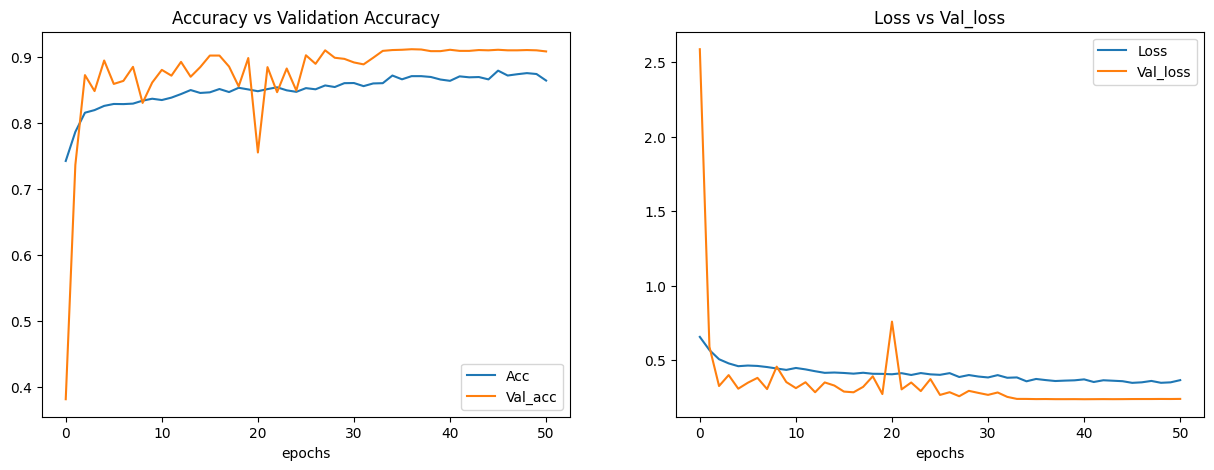

Training accuracy 0.8498679352741615
Validation accuracy 0.8751062072959601


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

### Experiment R7:  RESNET50, ADAM, Reduce initial learning rate to le-3

In [ ]:
from tensorflow.keras.applications import ResNet50

base_modelr4= ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

modelr4 = Sequential()
modelr4.add(base_modelr4)

for layer in modelr4.layers:
    layer.trainable = False

modelr4.add(keras.layers.Flatten(input_shape=(224,224,3)))
modelr4.add(Dropout(0.25))
modelr4.add(Dense(512,activation='relu'))
modelr4.add(BatchNormalization())
modelr4.add(Dropout(0.5))
modelr4.add(Dense(128,activation='relu'))
modelr4.add(Dropout(0.25))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

modelr4.add(tf.keras.layers.Dense(3, activation = 'softmax'))

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-3
##final_learning_rate = 0.00001
learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

callbacks = [EarlyStopping(monitor='val_loss', patience=10, mode= "min", restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

modelr4.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelr4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = modelr4.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 27s 45ms/step - loss: 0.6964 - accuracy: 0.7237 - val_loss: 0.4486 - val_accuracy: 0.8221
Epoch 2/100
300/300 [==============================] - 10s 32ms/step - loss: 0.5016 - accuracy: 0.8043 - val_loss: 0.3173 - val_accuracy: 0.8888
Epoch 3/100
300/300 [==============================] - 10s 33ms/step - loss: 0.4463 - accuracy: 0.8316 - val_loss: 0.2916 - val_accuracy: 0.8863
Epoch 4/100
300/300 [==============================] - 8s 25ms/step - loss: 0.4196 - accuracy: 0.8403 - val_loss: 0.3101 - val_accuracy: 0.8888
Epoch 5/100
300/300 [==============================] - 10s 32ms/step - loss: 0.3971 - accuracy: 0.8469 - val_loss: 0.2903 - val_accuracy: 0.8954
Epoch 6/100
300/300 [==============================] - 10s 33ms/step - loss: 0.3767 - accuracy: 0.8552 - val_loss: 0.2733 - val_accuracy: 0.8938
Epoch 7/100
300/300 [==============================] - 10s 32ms/step - loss: 0.3764 - accuracy: 0.8578 - val_loss: 0.2641 - val_acc

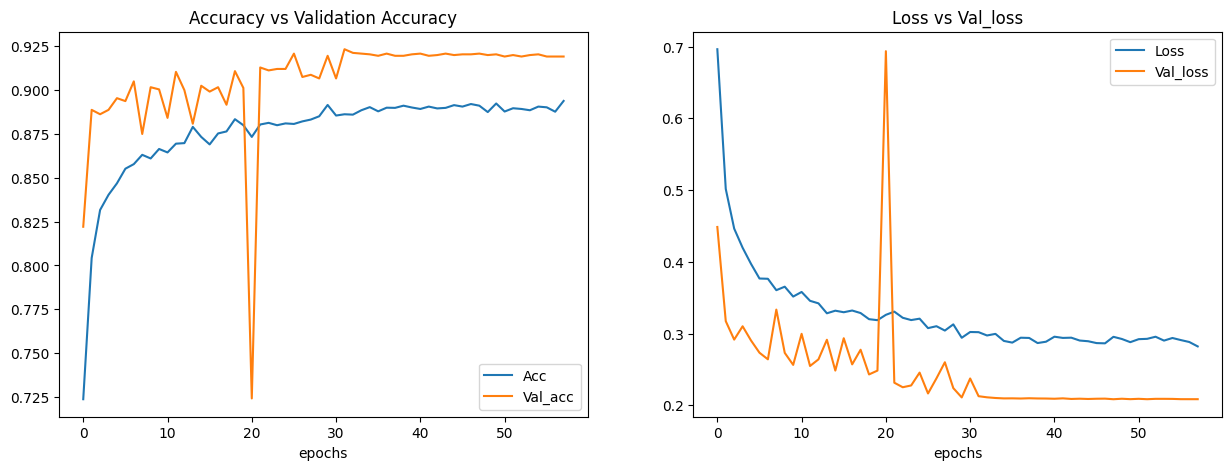

Training accuracy 0.876158076113668
Validation accuracy 0.9056465543549637


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

### Experiment R8:  RESNET50, ADAM, Reduce drop-outs to prevent under-fitting

In [ ]:
from tensorflow.keras.applications import ResNet50

base_modelr5= ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

modelr5 = Sequential()
modelr5.add(base_modelr5)

for layer in modelr5.layers:
    layer.trainable = False

modelr5.add(keras.layers.Flatten(input_shape=(224,224,3)))
modelr5.add(Dropout(0.25))
modelr5.add(Dense(512,activation='relu'))
#modelr5.add(BatchNormalization())
#modelr5.add(Dropout(0.25))
modelr5.add(Dense(128,activation='relu'))
modelr5.add(Dropout(0.25))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

modelr5.add(tf.keras.layers.Dense(3, activation = 'softmax'))

94765736/94765736 [==============================] - 6s 0us/step


In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-3

learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

callbacks = [EarlyStopping(monitor='val_loss', patience=10,  min_delta = 0.0001 , restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

modelr5.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelr5.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 3

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = modelr5.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 26s 46ms/step - loss: 1.3667 - accuracy: 0.5368 - val_loss: 0.7577 - val_accuracy: 0.7204
Epoch 2/100
300/300 [==============================] - 8s 27ms/step - loss: 0.8158 - accuracy: 0.6198 - val_loss: 0.7623 - val_accuracy: 0.7004
Epoch 3/100
300/300 [==============================] - 10s 33ms/step - loss: 0.7338 - accuracy: 0.6804 - val_loss: 0.6737 - val_accuracy: 0.7504
Epoch 4/100
300/300 [==============================] - 10s 33ms/step - loss: 0.6475 - accuracy: 0.7283 - val_loss: 0.5177 - val_accuracy: 0.8150
Epoch 5/100
300/300 [==============================] - 10s 32ms/step - loss: 0.5482 - accuracy: 0.7711 - val_loss: 0.3398 - val_accuracy: 0.8788
Epoch 6/100
300/300 [==============================] - 8s 26ms/step - loss: 0.5275 - accuracy: 0.7895 - val_loss: 0.3501 - val_accuracy: 0.8692
Epoch 7/100
300/300 [==============================] - 8s 26ms/step - loss: 0.4942 - accuracy: 0.8161 - val_loss: 0.4613 - val_accur

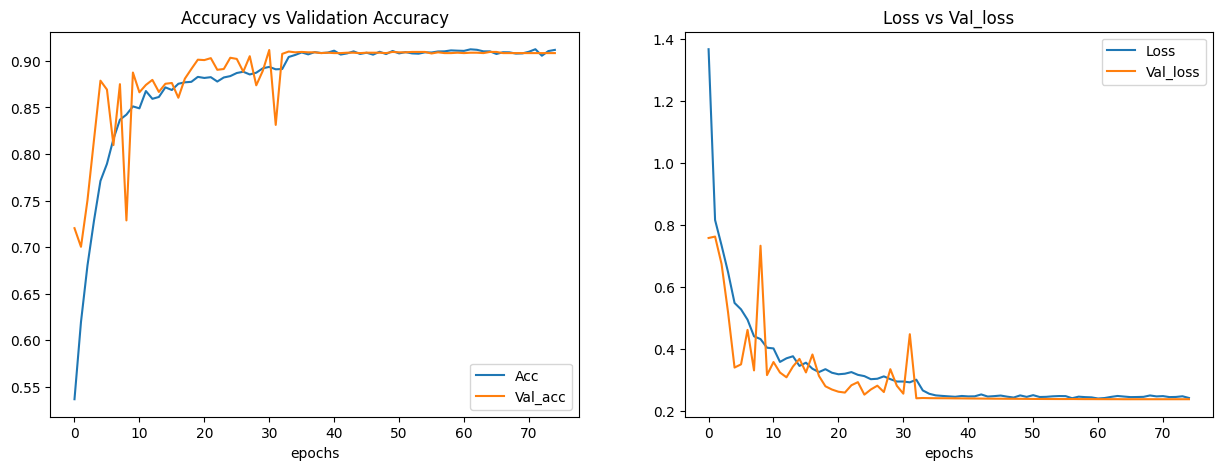

Training accuracy 0.8782123144467672
Validation accuracy 0.8876444538434346


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

### Experiment R9 - Reduce the drop out and learning rate further

In [ ]:
from tensorflow.keras.applications import ResNet50

base_modelr6= ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

modelr6 = Sequential()
modelr6.add(base_modelr6)

for layer in modelr6.layers:
    layer.trainable = False

modelr6.add(keras.layers.Flatten(input_shape=(224,224,3)))
#modelr6.add(Dropout(0.20))
modelr6.add(Dense(512,activation='relu'))
modelr6.add(BatchNormalization())
#modelr6.add(Dropout(0.20))
modelr6.add(Dense(128,activation='relu'))
modelr6.add(Dropout(0.20))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

modelr6.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-4

learning_rate_decay_factor = 0.0001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

callbacks = [EarlyStopping(monitor='val_loss', patience=10,  min_delta = 0.0001 , restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

modelr6.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelr6.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 512)               51380736  
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                      

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = modelr6.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 19s 50ms/step - loss: 0.3046 - accuracy: 0.8893 - val_loss: 2.9413 - val_accuracy: 0.3467
Epoch 2/100
300/300 [==============================] - 8s 26ms/step - loss: 0.2185 - accuracy: 0.9200 - val_loss: 3.1833 - val_accuracy: 0.6317
Epoch 3/100
300/300 [==============================] - 8s 25ms/step - loss: 0.1704 - accuracy: 0.9379 - val_loss: 6.3705 - val_accuracy: 0.3225
Epoch 4/100
300/300 [==============================] - 7s 25ms/step - loss: 0.1552 - accuracy: 0.9454 - val_loss: 4.0657 - val_accuracy: 0.6229
Epoch 5/100
300/300 [==============================] - 9s 31ms/step - loss: 0.1394 - accuracy: 0.9504 - val_loss: 1.4638 - val_accuracy: 0.5817
Epoch 6/100
300/300 [==============================] - 8s 25ms/step - loss: 0.1192 - accuracy: 0.9568 - val_loss: 5.3352 - val_accuracy: 0.3933
Epoch 7/100
300/300 [==============================] - 7s 25ms/step - loss: 0.1147 - accuracy: 0.9577 - val_loss: 17.1977 - val_accurac

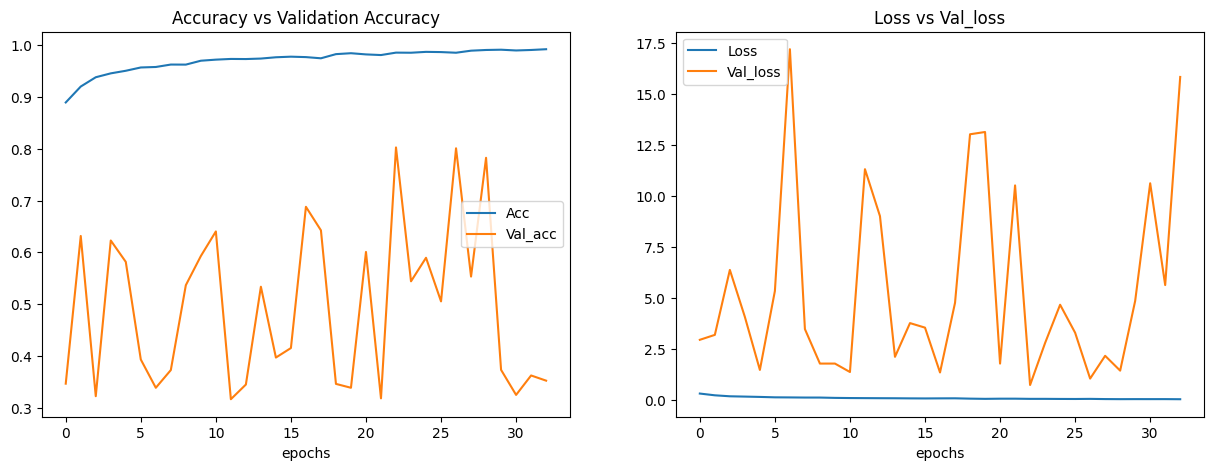

Training accuracy 0.9712343739740776
Validation accuracy 0.49438131668350915


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

### Experiment R10 - Reduce the decay rate and add the dropout back

In [ ]:
from tensorflow.keras.applications import ResNet50

base_modelr7= ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

modelr7 = Sequential()
modelr7.add(base_modelr7)

for layer in modelr7.layers:
    layer.trainable = False

modelr7.add(keras.layers.Flatten(input_shape=(224,224,3)))
#modelr7.add(Dropout(0.10))
modelr7.add(Dense(512,activation='relu'))
##modelr7.add(BatchNormalization())

modelr7.add(Dense(128,activation='relu'))
modelr7.add(Dropout(0.10))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

modelr7.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-5

learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

callbacks = [EarlyStopping(monitor='val_loss', patience=10,  min_delta = 0.0001 , restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

modelr7.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelr7.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_10 (Flatten)        (None, 100352)            0         
                                                                 
 dense_30 (Dense)            (None, 512)               51380736  
                                                                 
 dense_31 (Dense)            (None, 128)               65664     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 3)                 387       
                                                                 
Total params: 75,034,499
Trainable params: 51,446,787

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = modelr7.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 16s 42ms/step - loss: 0.8505 - accuracy: 0.6410 - val_loss: 0.6841 - val_accuracy: 0.7854
Epoch 2/100
300/300 [==============================] - 9s 32ms/step - loss: 0.6352 - accuracy: 0.7767 - val_loss: 0.5607 - val_accuracy: 0.8204
Epoch 3/100
300/300 [==============================] - 13s 43ms/step - loss: 0.5404 - accuracy: 0.8151 - val_loss: 0.4885 - val_accuracy: 0.8504
Epoch 4/100
300/300 [==============================] - 9s 31ms/step - loss: 0.4829 - accuracy: 0.8322 - val_loss: 0.4560 - val_accuracy: 0.8433
Epoch 5/100
300/300 [==============================] - 10s 34ms/step - loss: 0.4467 - accuracy: 0.8477 - val_loss: 0.4139 - val_accuracy: 0.8646
Epoch 6/100
300/300 [==============================] - 9s 31ms/step - loss: 0.4185 - accuracy: 0.8572 - val_loss: 0.3937 - val_accuracy: 0.8683
Epoch 7/100
300/300 [==============================] - 9s 31ms/step - loss: 0.3847 - accuracy: 0.8668 - val_loss: 0.3924 - val_accura

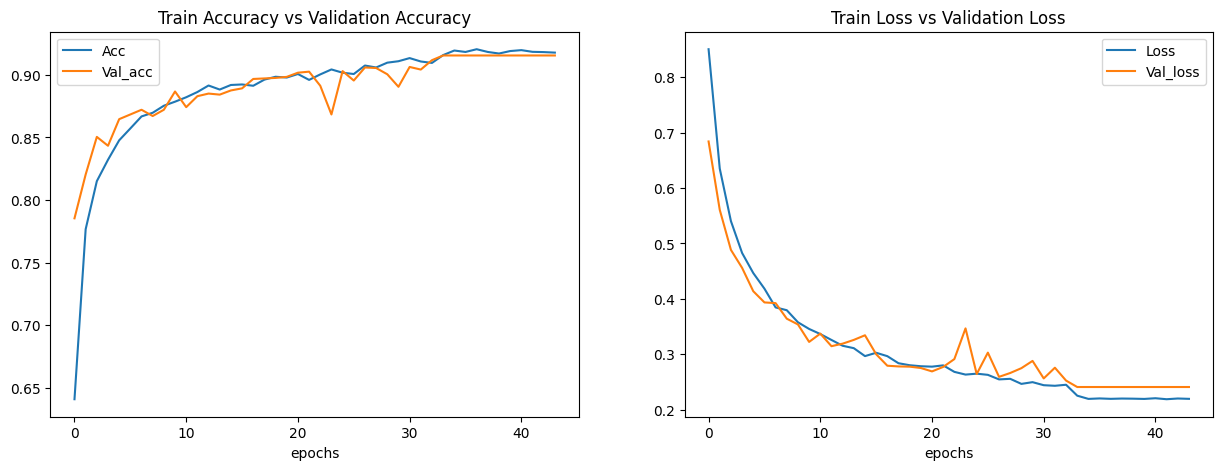

Training accuracy 0.8874551328745756
Validation accuracy 0.8904261291027069


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Train Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Train Loss vs Validation Loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

#### Make Predictions against Test set

In [ ]:
# make predictions on the testing set
y_pred = modelr7.predict(testX, batch_size=32)
print(y_pred.shape  )
print(testY.shape)

94/94 [==============================] - 3s 21ms/step
(3000, 3)
(3000,)


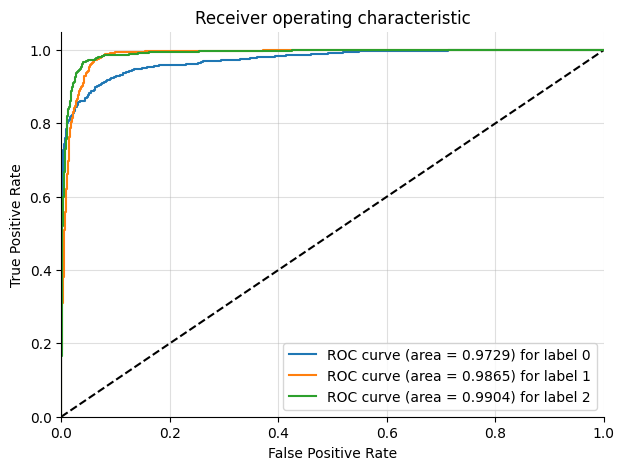

In [ ]:
from sklearn.preprocessing import label_binarize
def plot_multiclass_roc( testY, y_pred, n_classes, figsize=(12, 5)):


    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    ##y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    testY = label_binarize(testY, classes=[0,1,2])


    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(testY[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.4f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc( testY, y_pred, n_classes=3, figsize=(7,5 ))

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape  )
print(testY.shape)

print(classification_report(testY, y_pred, target_names=['Normal', 'Covid', 'Pneumonia'], digits=4))


(3000,)
(3000,)
              precision    recall  f1-score   support

      Normal     0.9293    0.8550    0.8906      1000
       Covid     0.8958    0.9630    0.9282      1000
   Pneumonia     0.9383    0.9430    0.9406      1000

    accuracy                         0.9203      3000
   macro avg     0.9212    0.9203    0.9198      3000
weighted avg     0.9212    0.9203    0.9198      3000



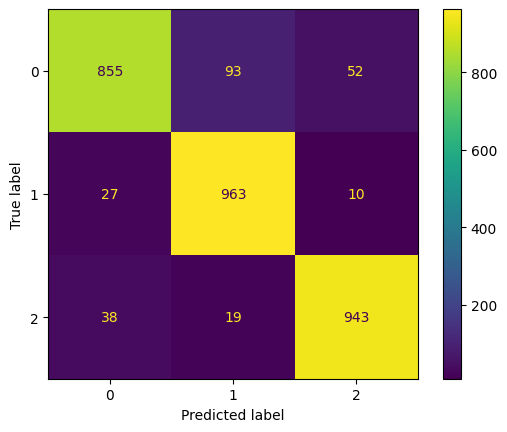


Test Accuracy: 0.9203


Test specificity Normal: 0.9675

Test specificity Covid: 0.9440

Test specificity Pnuemonia : 0.9690

Test specificity weighted average : 0.9592


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(testY, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Specificity = TN/TN + FP
####TN of C1" is all non-C1 instances that are not classified as C1.
#### "FP of C1" is all non-C1 instances that are classified as C1
specificity_normal = (cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2])/((cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2]) + (cm[1,0] + cm[2,0]))
specificity_covid = (cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0] )/((cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0]) + (cm[0,1] + cm[2,1]))
specificity_pnuemonia = (cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])/((cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1]) + (cm[0,2] + cm[1,2]))

specificity_weighted = (0.333 * specificity_normal) + (0.333 * specificity_covid) + (0.333 * specificity_pnuemonia)

# show the confusion matrix, accuracy, sensitivity, and specificity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nTest Accuracy: {:.4f}\n'.format(accuracy_score(testY, y_pred)))
print('\nTest specificity Normal: {:.4f}'.format(specificity_normal))
print('\nTest specificity Covid: {:.4f}'.format(specificity_covid))
print('\nTest specificity Pnuemonia : {:.4f}'.format(specificity_pnuemonia))
print('\nTest specificity weighted average : {:.4f}'.format(specificity_weighted))



### Experiment R10.1 - Reduce the decay rate and add the dropout back

In [ ]:
from tensorflow.keras.applications import ResNet50

base_modelr7= ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

modelr7 = Sequential()
modelr7.add(base_modelr7)

for layer in modelr7.layers:
    layer.trainable = False

modelr7.add(keras.layers.Flatten(input_shape=(224,224,3)))
#modelr7.add(Dropout(0.10))
modelr7.add(Dense(512,activation='relu'))
##modelr7.add(BatchNormalization())

modelr7.add(Dense(128,activation='relu'))
#modelr7.add(Dropout(0.10))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

modelr7.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-5

learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

callbacks = [EarlyStopping(monitor='val_loss', patience=10,  min_delta = 0.0001 , restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

modelr7.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelr7.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_11 (Flatten)        (None, 100352)            0         
                                                                 
 dense_33 (Dense)            (None, 512)               51380736  
                                                                 
 dense_34 (Dense)            (None, 128)               65664     
                                                                 
 dense_35 (Dense)            (None, 3)                 387       
                                                                 
Total params: 75,034,499
Trainable params: 51,446,787
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
epochs = 100
## Train the model for 30 epochs

history = modelr7.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 20s 55ms/step - loss: 0.8206 - accuracy: 0.6645 - val_loss: 0.6763 - val_accuracy: 0.7921
Epoch 2/100
300/300 [==============================] - 13s 43ms/step - loss: 0.6225 - accuracy: 0.7876 - val_loss: 0.5763 - val_accuracy: 0.8096
Epoch 3/100
300/300 [==============================] - 11s 36ms/step - loss: 0.5224 - accuracy: 0.8253 - val_loss: 0.4731 - val_accuracy: 0.8517
Epoch 4/100
300/300 [==============================] - 10s 35ms/step - loss: 0.4548 - accuracy: 0.8484 - val_loss: 0.4619 - val_accuracy: 0.8317
Epoch 5/100
300/300 [==============================] - 11s 36ms/step - loss: 0.4172 - accuracy: 0.8602 - val_loss: 0.3922 - val_accuracy: 0.8704
Epoch 6/100
300/300 [==============================] - 9s 31ms/step - loss: 0.3954 - accuracy: 0.8645 - val_loss: 0.3894 - val_accuracy: 0.8775
Epoch 7/100
300/300 [==============================] - 7s 24ms/step - loss: 0.3699 - accuracy: 0.8745 - val_loss: 0.3922 - val_accu

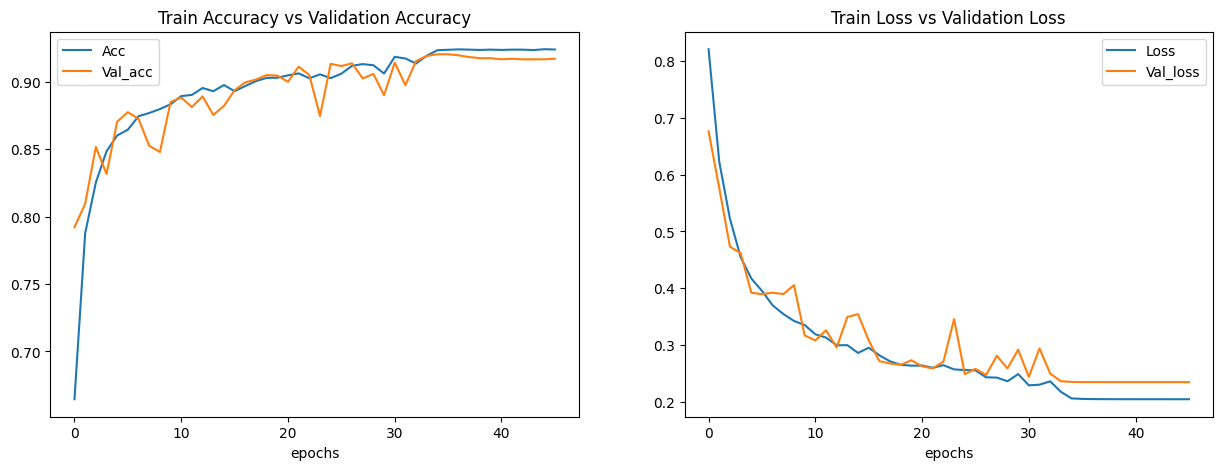

Training accuracy 0.8946176456368488
Validation accuracy 0.8934873174066129


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Train Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Train Loss vs Validation Loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

#### Make Predictions against Test set

In [ ]:
# make predictions on the testing set
y_pred = modelr7.predict(testX, batch_size=32)
print(y_pred.shape  )
print(testY.shape)

94/94 [==============================] - 3s 17ms/step
(3000, 3)
(3000,)


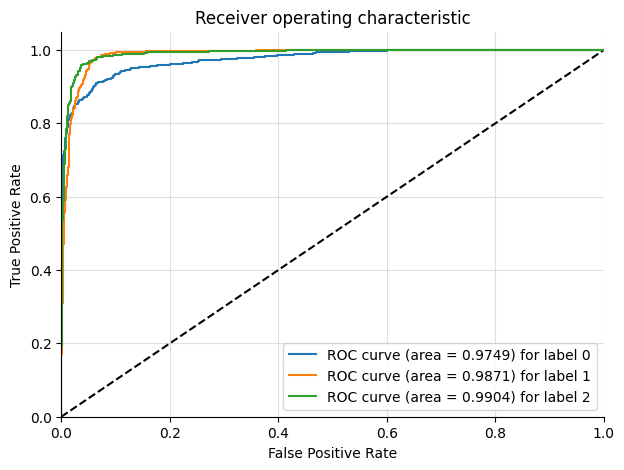

In [ ]:
from sklearn.preprocessing import label_binarize
def plot_multiclass_roc( testY, y_pred, n_classes, figsize=(12, 5)):


    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    ##y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    testY = label_binarize(testY, classes=[0,1,2])


    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(testY[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.4f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc( testY, y_pred, n_classes=3, figsize=(7,5 ))

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape  )
print(testY.shape)

print(classification_report(testY, y_pred, target_names=['Normal', 'Covid', 'Pneumonia'], digits=4))


(3000,)
(3000,)
              precision    recall  f1-score   support

      Normal     0.9241    0.8640    0.8930      1000
       Covid     0.9017    0.9630    0.9313      1000
   Pneumonia     0.9418    0.9390    0.9404      1000

    accuracy                         0.9220      3000
   macro avg     0.9225    0.9220    0.9216      3000
weighted avg     0.9225    0.9220    0.9216      3000



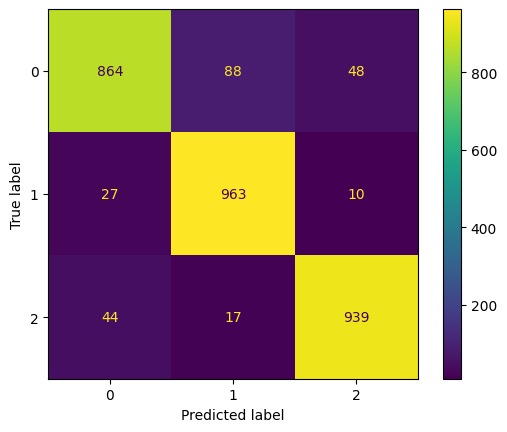


Test Accuracy: 0.9220


Test specificity Normal: 0.9645

Test specificity Covid: 0.9475

Test specificity Pnuemonia : 0.9710

Test specificity weighted average : 0.9600


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(testY, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Specificity = TN/TN + FP
####TN of C1" is all non-C1 instances that are not classified as C1.
#### "FP of C1" is all non-C1 instances that are classified as C1
specificity_normal = (cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2])/((cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2]) + (cm[1,0] + cm[2,0]))
specificity_covid = (cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0] )/((cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0]) + (cm[0,1] + cm[2,1]))
specificity_pnuemonia = (cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])/((cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1]) + (cm[0,2] + cm[1,2]))

specificity_weighted = (0.333 * specificity_normal) + (0.333 * specificity_covid) + (0.333 * specificity_pnuemonia)

# show the confusion matrix, accuracy, sensitivity, and specificity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nTest Accuracy: {:.4f}\n'.format(accuracy_score(testY, y_pred)))
print('\nTest specificity Normal: {:.4f}'.format(specificity_normal))
print('\nTest specificity Covid: {:.4f}'.format(specificity_covid))
print('\nTest specificity Pnuemonia : {:.4f}'.format(specificity_pnuemonia))
print('\nTest specificity weighted average : {:.4f}'.format(specificity_weighted))



### Experiment R11 - Reduce the learning  rate and drop the dropout

In [ ]:
from tensorflow.keras.applications import ResNet50

base_modelr8= ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

modelr8 = Sequential()
modelr8.add(base_modelr8)

for layer in modelr8.layers:
    layer.trainable = False

modelr8.add(keras.layers.Flatten(input_shape=(224,224,3)))
modelr8.add(Dropout(0.10))
modelr8.add(Dense(512,activation='relu'))
modelr8.add(BatchNormalization())

modelr8.add(Dense(128,activation='relu'))
modelr8.add(Dropout(0.10))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

modelr8.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-3

learning_rate_decay_factor = 0.00001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

callbacks = [EarlyStopping(monitor='val_loss', patience=10,  min_delta = 0.0001 , restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

modelr8.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelr8.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_12 (Flatten)        (None, 100352)            0         
                                                                 
 dropout_19 (Dropout)        (None, 100352)            0         
                                                                 
 dense_36 (Dense)            (None, 512)               51380736  
                                                                 
 batch_normalization_12 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_37 (Dense)            (None, 128)               65664     
                                                     

In [ ]:
epochs = 100
## Train the model for 30 epochs

history = modelr8.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 17s 42ms/step - loss: 0.4767 - accuracy: 0.8145 - val_loss: 4.4875 - val_accuracy: 0.4004
Epoch 2/100
300/300 [==============================] - 10s 33ms/step - loss: 0.3681 - accuracy: 0.8621 - val_loss: 0.3878 - val_accuracy: 0.8475
Epoch 3/100
300/300 [==============================] - 14s 46ms/step - loss: 0.3200 - accuracy: 0.8750 - val_loss: 0.3119 - val_accuracy: 0.8833
Epoch 4/100
300/300 [==============================] - 12s 41ms/step - loss: 0.3025 - accuracy: 0.8847 - val_loss: 0.3116 - val_accuracy: 0.8783
Epoch 5/100
300/300 [==============================] - 14s 47ms/step - loss: 0.2884 - accuracy: 0.8870 - val_loss: 0.2453 - val_accuracy: 0.9108
Epoch 6/100
300/300 [==============================] - 8s 25ms/step - loss: 0.2710 - accuracy: 0.8943 - val_loss: 0.2997 - val_accuracy: 0.8888
Epoch 7/100
300/300 [==============================] - 8s 25ms/step - loss: 0.2633 - accuracy: 0.8971 - val_loss: 0.5793 - val_accu

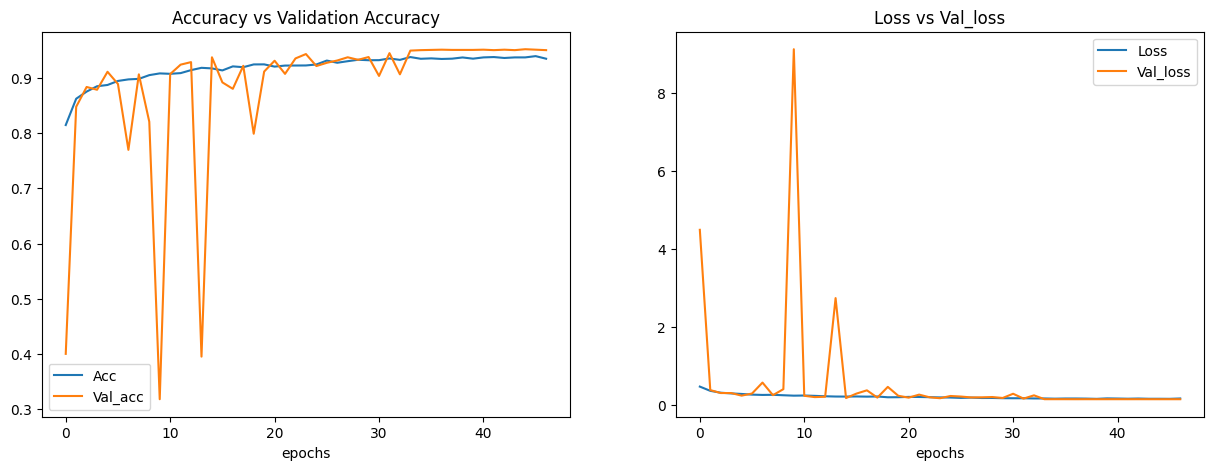

Training accuracy 0.9182627632262859
Validation accuracy 0.8825709211065415


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

###Experiment D1: DenseNet201, Adam

In [ ]:
from tensorflow.keras.applications import DenseNet201

base_modeld1= DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))


modeld1 = Sequential()
modeld1.add(base_modeld1)

for layer in modeld1.layers:
    layer.trainable = False


modeld1.add(keras.layers.Flatten(input_shape=(224,224,3)))
modeld1.add(Dropout(0.25))
modeld1.add(Dense(128,activation='relu'))
modeld1.add(Dropout(0.5))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

modeld1.add(tf.keras.layers.Dense(3, activation = 'softmax'))

74836368/74836368 [==============================] - 5s 0us/step


In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded

modeld1.compile(optimizer = 'Adam',
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modeld1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten_2 (Flatten)         (None, 94080)             0         
                                                                 
 dropout_5 (Dropout)         (None, 94080)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               12042368  
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 387       
                                                                 
Total params: 30,364,739
Trainable params: 12,042,755


In [ ]:
epochs = 100
## Train the model for 20 epochs

history = modeld1.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 14s 47ms/step - loss: 0.0854 - accuracy: 0.9711 - val_loss: 0.1055 - val_accuracy: 0.9712
Epoch 2/100
300/300 [==============================] - 13s 42ms/step - loss: 0.0869 - accuracy: 0.9681 - val_loss: 0.1367 - val_accuracy: 0.9671
Epoch 3/100
300/300 [==============================] - 12s 41ms/step - loss: 0.0906 - accuracy: 0.9664 - val_loss: 0.1198 - val_accuracy: 0.9646
Epoch 4/100
300/300 [==============================] - 14s 46ms/step - loss: 0.0860 - accuracy: 0.9684 - val_loss: 0.1054 - val_accuracy: 0.9708
Epoch 5/100
300/300 [==============================] - 13s 42ms/step - loss: 0.0637 - accuracy: 0.9775 - val_loss: 0.1114 - val_accuracy: 0.9654
Epoch 6/100
300/300 [==============================] - 12s 41ms/step - loss: 0.0850 - accuracy: 0.9687 - val_loss: 0.1797 - val_accuracy: 0.9613
Epoch 7/100
300/300 [==============================] - 12s 41ms/step - loss: 0.0818 - accuracy: 0.9708 - val_loss: 0.1075 - val_ac

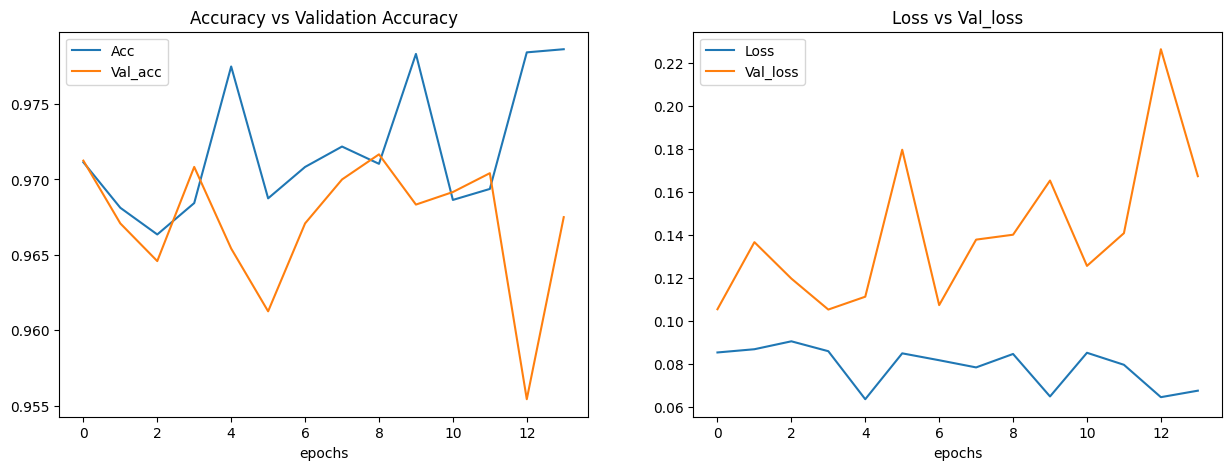

Training accuracy 0.9719836924757276
Validation accuracy 0.9671428629330227


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

### Experiment D2: DenseNet201, Adam, learning rate





In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-2

learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

## Pateince changed to 8
callbacks = [EarlyStopping(monitor='val_loss', patience=10, mode= "min", restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

modeld1.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modeld1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten_2 (Flatten)         (None, 94080)             0         
                                                                 
 dropout_5 (Dropout)         (None, 94080)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               12042368  
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 387       
                                                                 
Total params: 30,364,739
Trainable params: 12,042,755


In [ ]:
epochs = 100
## Train the model for 20 epochs

history = modeld1.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 31s 68ms/step - loss: 0.7705 - accuracy: 0.7760 - val_loss: 0.5233 - val_accuracy: 0.8929
Epoch 2/100
300/300 [==============================] - 13s 42ms/step - loss: 1.0337 - accuracy: 0.6023 - val_loss: 0.7007 - val_accuracy: 0.7008
Epoch 3/100
300/300 [==============================] - 13s 42ms/step - loss: 1.2204 - accuracy: 0.5460 - val_loss: 0.9569 - val_accuracy: 0.4750
Epoch 4/100
300/300 [==============================] - 12s 42ms/step - loss: 1.0023 - accuracy: 0.5049 - val_loss: 0.9688 - val_accuracy: 0.7708
Epoch 5/100
300/300 [==============================] - 13s 42ms/step - loss: 0.8770 - accuracy: 0.5904 - val_loss: 0.8832 - val_accuracy: 0.7679
Epoch 6/100
300/300 [==============================] - 13s 42ms/step - loss: 1.0172 - accuracy: 0.5732 - val_loss: 0.5760 - val_accuracy: 0.8283
Epoch 7/100
300/300 [==============================] - 13s 43ms/step - loss: 0.9459 - accuracy: 0.5436 - val_loss: 0.7124 - val_ac

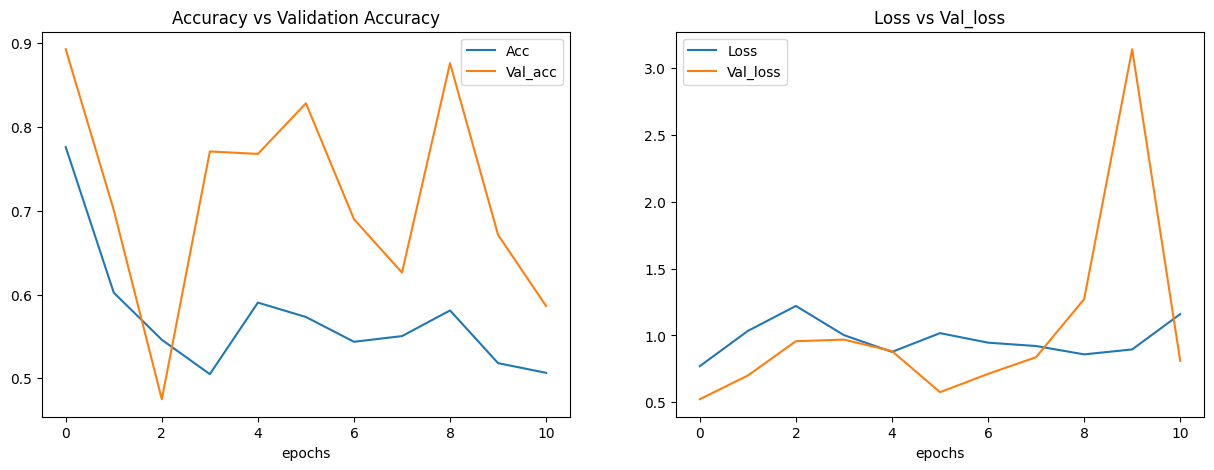

Training accuracy 0.5720292871648615
Validation accuracy 0.7168939411640167


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

####Experiment D3- Adam, learning rate, Initial learning rate reduced to 0.0001

In [ ]:
from tensorflow.keras.applications import DenseNet201

base_modeld3= DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))


modeld3 = Sequential()
modeld3.add(base_modeld3)

for layer in modeld3.layers:
    layer.trainable = False


modeld3.add(keras.layers.Flatten(input_shape=(224,224,3)))
modeld3.add(Dropout(0.25))
##modeld3.add(BatchNormalization())
modeld3.add(Dense(128,activation='relu'))
modeld3.add(Dropout(0.5))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

modeld3.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()

#epochs = 30

initial_learning_rate =  1e-3

learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


callbacks = [EarlyStopping(monitor='val_loss', patience=10, mode= "min", restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

modeld3.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modeld3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten_1 (Flatten)         (None, 94080)             0         
                                                                 
 dropout_2 (Dropout)         (None, 94080)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               12042368  
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 30,364,739
Trainable params: 12,042,755


In [ ]:
epochs = 100
## Train the model for 20 epochs

history = modeld3.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 30s 63ms/step - loss: 0.5276 - accuracy: 0.8756 - val_loss: 0.1589 - val_accuracy: 0.9429
Epoch 2/100
300/300 [==============================] - 12s 41ms/step - loss: 0.2227 - accuracy: 0.9150 - val_loss: 0.1939 - val_accuracy: 0.9379
Epoch 3/100
300/300 [==============================] - 14s 47ms/step - loss: 0.2132 - accuracy: 0.9199 - val_loss: 0.1287 - val_accuracy: 0.9550
Epoch 4/100
300/300 [==============================] - 13s 42ms/step - loss: 0.1732 - accuracy: 0.9332 - val_loss: 0.1324 - val_accuracy: 0.9583
Epoch 5/100
300/300 [==============================] - 14s 47ms/step - loss: 0.1566 - accuracy: 0.9419 - val_loss: 0.1153 - val_accuracy: 0.9600
Epoch 6/100
300/300 [==============================] - 14s 46ms/step - loss: 0.1501 - accuracy: 0.9459 - val_loss: 0.0942 - val_accuracy: 0.9617
Epoch 7/100
300/300 [==============================] - 12s 41ms/step - loss: 0.1226 - accuracy: 0.9535 - val_loss: 0.0944 - val_ac

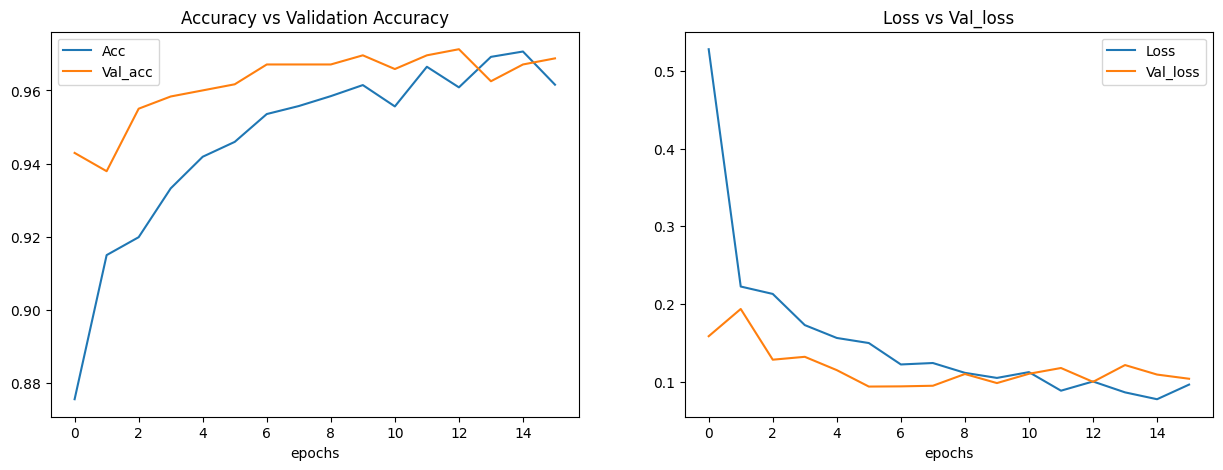

Training accuracy 0.9465569332242012
Validation accuracy 0.9619791619479656


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

#### Make Predictions against Test set

In [ ]:
# make predictions on the Test set
print("[INFO] evaluating network...")
print( len(testX))

y_pred = modeld3.predict(testX, batch_size=32)
print(y_pred.shape  )
print(testY.shape)

y_pred = np.argmax(y_pred, axis=1)

print(classification_report(testY, y_pred, target_names=['Normal', 'Covid', 'Pneumonia'], digits=4))

[INFO] evaluating network...
3000
94/94 [==============================] - 6s 31ms/step
(3000, 3)
(3000,)
              precision    recall  f1-score   support

      Normal     0.9443    0.9500    0.9472      1000
       Covid     0.9747    0.9650    0.9698      1000
   Pneumonia     0.9701    0.9740    0.9721      1000

    accuracy                         0.9630      3000
   macro avg     0.9631    0.9630    0.9630      3000
weighted avg     0.9631    0.9630    0.9630      3000



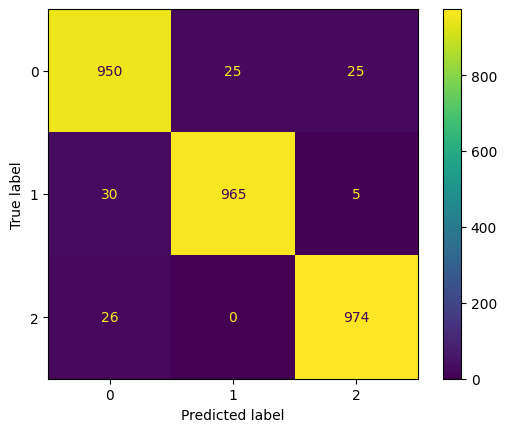


Test Accuracy: 0.9630


Test Precision score:{:.4f}
 [0.944334   0.97474747 0.97011952]

Test Recall score:{:.4f}
 [0.95  0.965 0.974]

Test specificity: 0.9698

Test F1 score:{:.4f}
 [0.94715852 0.96984925 0.97205589]


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(testY, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nTest Accuracy: {:.4f}\n'.format(accuracy_score(testY, y_pred)))
print('\nTest Precision score:{:.4f}\n', precision_score(testY, y_pred, average=None))
print('\nTest Recall score:{:.4f}\n', recall_score(testY, y_pred, average=None))
print('\nTest specificity: {:.4f}'.format(specificity))
print('\nTest F1 score:{:.4f}\n' ,f1_score(testY, y_pred, average=None))



####Experiment D4: DenseNet201, sgd

In [ ]:
from tensorflow.keras.applications import DenseNet201

base_modeld4= DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))


modeld4 = Sequential()
modeld4.add(base_modeld4)

for layer in modeld4.layers:
    layer.trainable = False


modeld4.add(keras.layers.Flatten(input_shape=(224,224,3)))
modeld4.add(Dropout(0.25))
##modeld4.add(BatchNormalization())
modeld4.add(Dense(128,activation='relu'))
modeld4.add(Dropout(0.5))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

modeld4.add(tf.keras.layers.Dense(3, activation = 'softmax'))

74836368/74836368 [==============================] - 4s 0us/step


In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()


initial_learning_rate =  1e-3

learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


callbacks = [EarlyStopping(monitor='val_loss', patience=10, mode= "min", restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

modeld4.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modeld4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten_1 (Flatten)         (None, 94080)             0         
                                                                 
 dropout_3 (Dropout)         (None, 94080)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               12042368  
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                                 
Total params: 30,364,739
Trainable params: 12,042,755


In [ ]:
epochs = 100
## Train the model for 20 epochs

history = modeld4.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 30s 63ms/step - loss: 0.3341 - accuracy: 0.8773 - val_loss: 0.1683 - val_accuracy: 0.9354
Epoch 2/100
300/300 [==============================] - 14s 46ms/step - loss: 0.1847 - accuracy: 0.9347 - val_loss: 0.1389 - val_accuracy: 0.9471
Epoch 3/100
300/300 [==============================] - 14s 47ms/step - loss: 0.1550 - accuracy: 0.9424 - val_loss: 0.1311 - val_accuracy: 0.9488
Epoch 4/100
300/300 [==============================] - 14s 45ms/step - loss: 0.1344 - accuracy: 0.9538 - val_loss: 0.1137 - val_accuracy: 0.9538
Epoch 5/100
300/300 [==============================] - 12s 41ms/step - loss: 0.1132 - accuracy: 0.9584 - val_loss: 0.1156 - val_accuracy: 0.9550
Epoch 6/100
300/300 [==============================] - 14s 46ms/step - loss: 0.1121 - accuracy: 0.9593 - val_loss: 0.1005 - val_accuracy: 0.9642
Epoch 7/100
300/300 [==============================] - 14s 46ms/step - loss: 0.0959 - accuracy: 0.9647 - val_loss: 0.0973 - val_ac

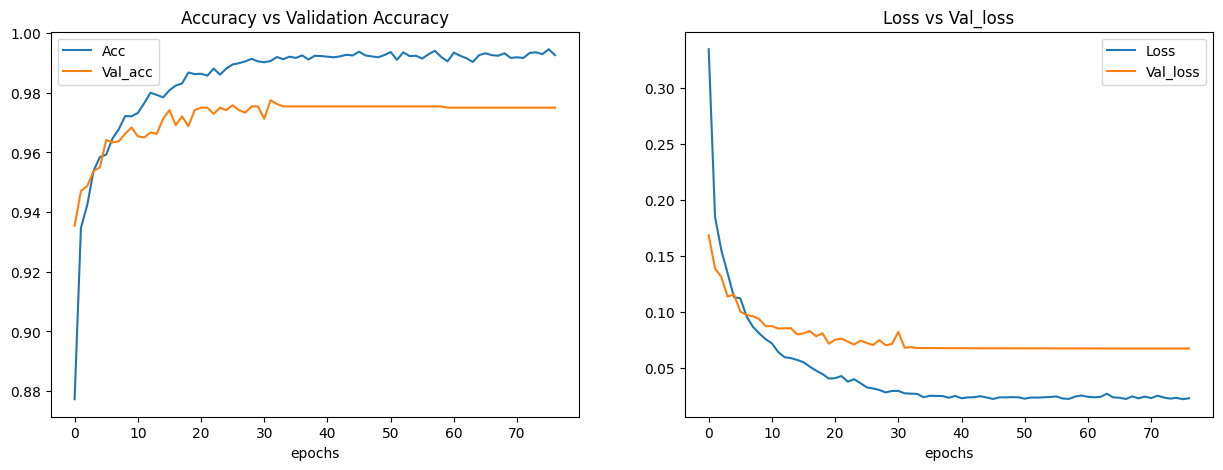

Training accuracy 0.9848536701945515
Validation accuracy 0.9719588795265595


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

#### Make Predictions against Test set

In [ ]:
# make predictions on the testing set
y_pred = modeld4.predict(testX, batch_size=32)
print(y_pred.shape  )
print(testY.shape)

94/94 [==============================] - 3s 29ms/step
(3000, 3)
(3000,)


(3000, 3)
(3000, 3)


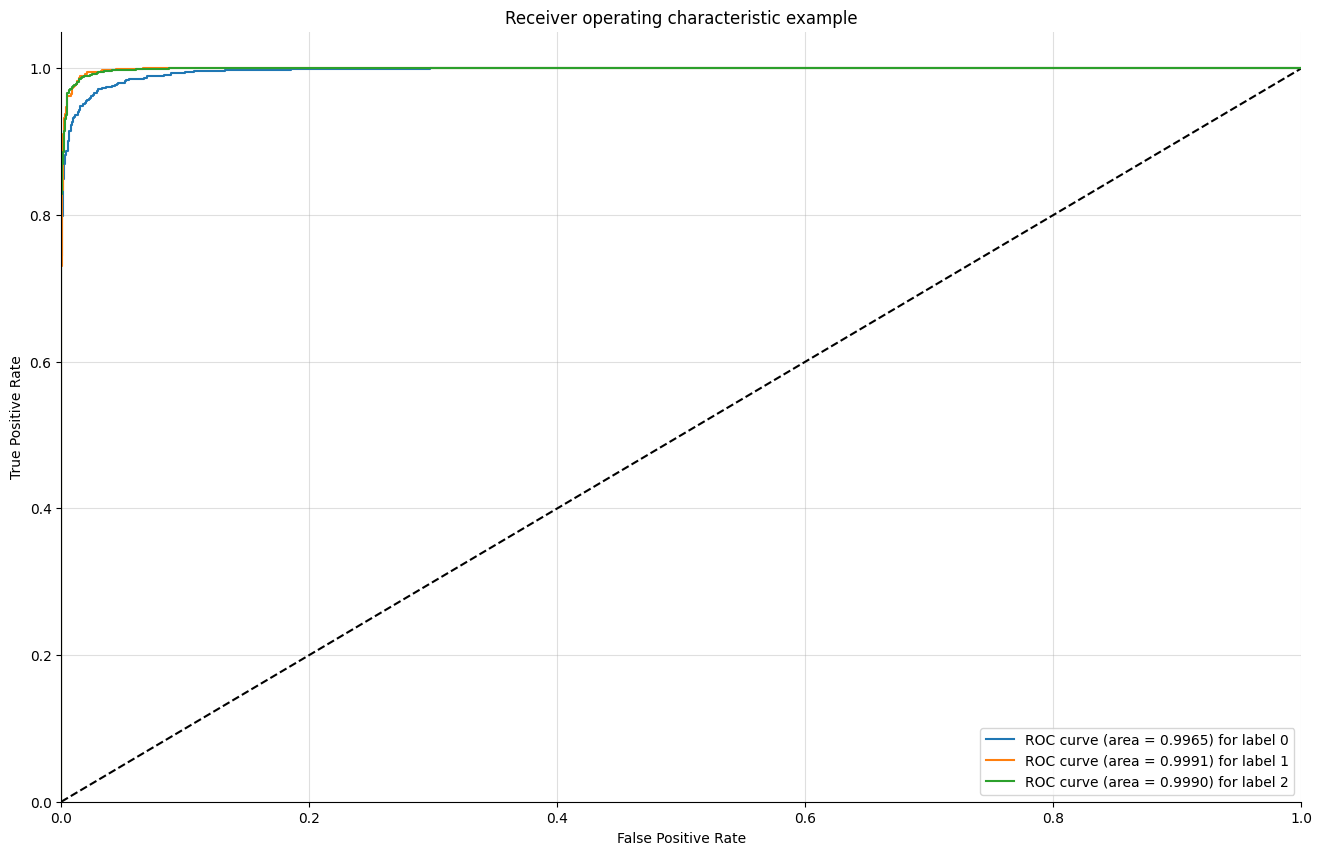

In [ ]:
from sklearn.preprocessing import label_binarize
def plot_multiclass_roc( testY, y_pred, n_classes, figsize=(17, 6)):


    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    ##y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    testY = label_binarize(testY, classes=[0,1,2])

    print(y_pred.shape)
    print(testY.shape)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(testY[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.4f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc( testY, y_pred, n_classes=3, figsize=(16, 10))

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape  )
print(testY.shape)

print(classification_report(testY, y_pred, target_names=['Normal', 'Covid', 'Pneumonia'], digits=4))


(3000,)
(3000,)
              precision    recall  f1-score   support

      Normal     0.9635    0.9510    0.9572      1000
       Covid     0.9714    0.9860    0.9787      1000
   Pneumonia     0.9790    0.9770    0.9780      1000

    accuracy                         0.9713      3000
   macro avg     0.9713    0.9713    0.9713      3000
weighted avg     0.9713    0.9713    0.9713      3000



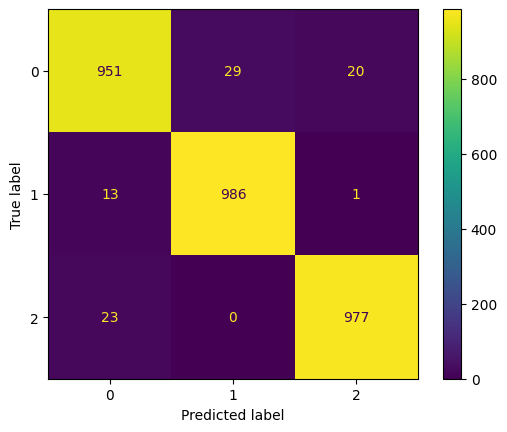


Test Accuracy: 0.9713


Test specificity Normal: 0.9820

Test specificity Covid: 0.9855

Test specificity Pnuemonia : 0.9895


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(testY, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


specificity_normal = (cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2])/((cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2]) + (cm[1,0] + cm[2,0]))
specificity_covid = (cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0] )/((cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0]) + (cm[0,1] + cm[2,1]))
specificity_pnuemonia = (cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])/((cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1]) + (cm[0,2] + cm[1,2]))
### Specificity = TN/TN + FP

####TN of C1" is all non-C1 instances that are not classified as C1.
#### "FP of C1" is all non-C1 instances that are classified as C1.

# show the confusion matrix, accuracy, sensitivity, and specificity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nTest Accuracy: {:.4f}\n'.format(accuracy_score(testY, y_pred)))
print('\nTest specificity Normal: {:.4f}'.format(specificity_normal))
print('\nTest specificity Covid: {:.4f}'.format(specificity_covid))
print('\nTest specificity Pnuemonia : {:.4f}'.format(specificity_pnuemonia))



####Experiment D4: DenseNet201, sgd , same as earlier experiment with min_delta in EarlyStopping

In [ ]:
from tensorflow.keras.applications import DenseNet201

base_modeld5= DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))


modeld5 = Sequential()
modeld5.add(base_modeld5)

for layer in modeld5.layers:
    layer.trainable = False


modeld5.add(keras.layers.Flatten(input_shape=(224,224,3)))
modeld5.add(Dropout(0.25))
##modeld5.add(BatchNormalization())
modeld5.add(Dense(128,activation='relu'))
modeld5.add(Dropout(0.5))

## Final Dense layer with activation fumction = 'softmax' ( for classification)

modeld5.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
### Lets use optimizer= Adam  and loss function  = 'sparse_categorical_crossentropy'. We are using sparse_categorical_crossentropy because the
### labels (target variable) are integers (train_ds.labels) and not one-hot encoded
#optimiser = optimizers.sgd()


initial_learning_rate =  1e-3

learning_rate_decay_factor = 0.001  ##(final_learning_rate / initial_learning_rate)**(1/epochs)    ## Changed decay factor from 0.9 to 0.001
steps_per_epoch = 10000  ### int(len(trainX)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


callbacks = [EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.0001, mode= "min", restore_best_weights=True),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

modeld5.compile(optimizer = opt,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

modeld5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 94080)             0         
                                                                 
 dropout (Dropout)           (None, 94080)             0         
                                                                 
 dense (Dense)               (None, 128)               12042368  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 30,364,739
Trainable params: 12,042,755
No

In [ ]:
epochs = 100
## Train the model for 20 epochs

history = modeld5.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 39s 65ms/step - loss: 0.3197 - accuracy: 0.8779 - val_loss: 0.1624 - val_accuracy: 0.9400
Epoch 2/100
300/300 [==============================] - 13s 45ms/step - loss: 0.1854 - accuracy: 0.9310 - val_loss: 0.1429 - val_accuracy: 0.9517
Epoch 3/100
300/300 [==============================] - 13s 44ms/step - loss: 0.1485 - accuracy: 0.9443 - val_loss: 0.1308 - val_accuracy: 0.9504
Epoch 4/100
300/300 [==============================] - 13s 44ms/step - loss: 0.1326 - accuracy: 0.9557 - val_loss: 0.1171 - val_accuracy: 0.9558
Epoch 5/100
300/300 [==============================] - 13s 44ms/step - loss: 0.1180 - accuracy: 0.9568 - val_loss: 0.1148 - val_accuracy: 0.9554
Epoch 6/100
300/300 [==============================] - 13s 45ms/step - loss: 0.1072 - accuracy: 0.9604 - val_loss: 0.1030 - val_accuracy: 0.9600
Epoch 7/100
300/300 [==============================] - 13s 44ms/step - loss: 0.0973 - accuracy: 0.9654 - val_loss: 0.0969 - val_ac

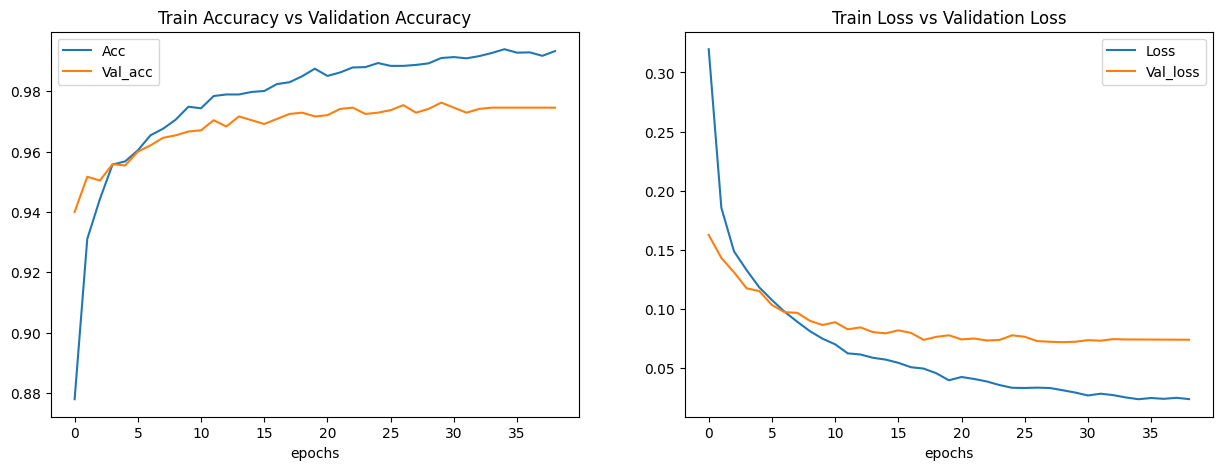

Training accuracy 0.9776205313511384
Validation accuracy 0.9688461560469407


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Train Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Train Loss vs Validation Loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

#### Make Predictions against Test set

In [ ]:
# make predictions on the testing set
y_pred = modeld5.predict(testX, batch_size=32)
print(y_pred.shape  )
print(testY.shape)

94/94 [==============================] - 6s 31ms/step
(3000, 3)
(3000,)


(3000, 3)
(3000, 3)


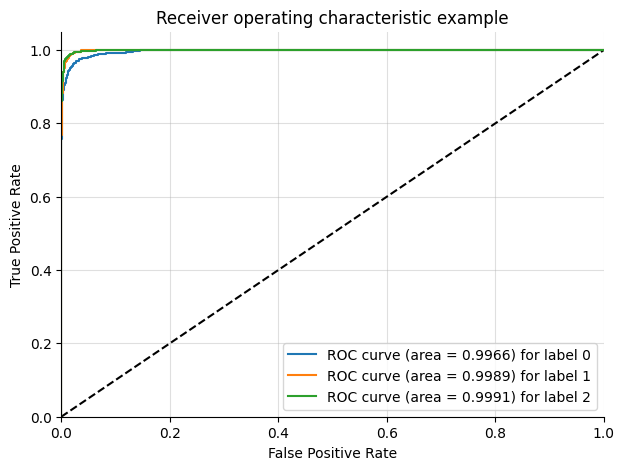

In [ ]:
from sklearn.preprocessing import label_binarize
def plot_multiclass_roc( testY, y_pred, n_classes, figsize=(12, 5)):


    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    ##y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    testY = label_binarize(testY, classes=[0,1,2])

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(testY[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.4f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc( testY, y_pred, n_classes=3, figsize=(7,5 ))

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape  )
print(testY.shape)

print(classification_report(testY, y_pred, target_names=['Normal', 'Covid', 'Pneumonia'], digits=4))


(3000,)
(3000,)
              precision    recall  f1-score   support

      Normal     0.9617    0.9540    0.9578      1000
       Covid     0.9751    0.9790    0.9770      1000
   Pneumonia     0.9761    0.9800    0.9780      1000

    accuracy                         0.9710      3000
   macro avg     0.9710    0.9710    0.9710      3000
weighted avg     0.9710    0.9710    0.9710      3000



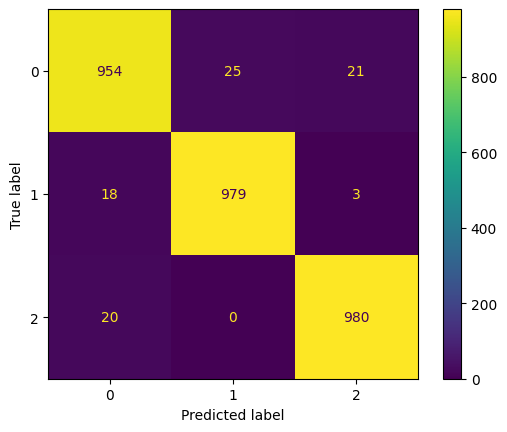


Test Accuracy: 0.9710


Test specificity Normal: 0.9810

Test specificity Covid: 0.9875

Test specificity Pnuemonia : 0.9880

Test specificity weighted average : 0.9845


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(testY, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Specificity = TN/TN + FP
####TN of C1" is all non-C1 instances that are not classified as C1.
#### "FP of C1" is all non-C1 instances that are classified as C1
specificity_normal = (cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2])/((cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2]) + (cm[1,0] + cm[2,0]))
specificity_covid = (cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0] )/((cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0]) + (cm[0,1] + cm[2,1]))
specificity_pnuemonia = (cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])/((cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1]) + (cm[0,2] + cm[1,2]))

specificity_weighted = (0.333 * specificity_normal) + (0.333 * specificity_covid) + (0.333 * specificity_pnuemonia)

# show the confusion matrix, accuracy, sensitivity, and specificity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nTest Accuracy: {:.4f}\n'.format(accuracy_score(testY, y_pred)))
print('\nTest specificity Normal: {:.4f}'.format(specificity_normal))
print('\nTest specificity Covid: {:.4f}'.format(specificity_covid))
print('\nTest specificity Pnuemonia : {:.4f}'.format(specificity_pnuemonia))
print('\nTest specificity weighted average : {:.4f}'.format(specificity_weighted))



####Experiment C1: CheXNet, SGD

In [ ]:
from tensorflow.keras.applications import densenet


base_modelc1 = densenet.DenseNet121(weights=None, include_top=False,
                       input_shape=(224, 224, 3), pooling="avg")

for layer in base_modelc1.layers:
    layer.trainable = False

output = tf.keras.layers.Dense(14, activation='softmax', name='output')(base_modelc1.layers[-1].output)
modelc1 = tf.keras.Model(inputs=[base_modelc1.input], outputs=[output])

## loading CheXNet weights
modelc1.load_weights("/content/gdrive/My Drive/CheXNet_Weights/CheXNet_Keras_0.3.0_weights.h5")


print("CheXNet loaded")

CheXNet loaded


In [ ]:

from tensorflow.keras.optimizers import SGD

import tensorflow as tf
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate= 0.01,
    decay_steps=10000,
    decay_rate=0.09)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
callbacks = [EarlyStopping(monitor='val_loss', patience=10),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

modelc1.compile(optimizer,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])


modelc1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                             

In [ ]:
epochs = 100
## Train the model for 20 epochs

history = modelc1.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks= callbacks
)


Epoch 1/100
300/300 [==============================] - 19s 42ms/step - loss: 1.3003 - accuracy: 0.4815 - val_loss: 0.8104 - val_accuracy: 0.6825
Epoch 2/100
300/300 [==============================] - 9s 30ms/step - loss: 0.7127 - accuracy: 0.7279 - val_loss: 0.6421 - val_accuracy: 0.7713
Epoch 3/100
300/300 [==============================] - 9s 31ms/step - loss: 0.6082 - accuracy: 0.7814 - val_loss: 0.5759 - val_accuracy: 0.8083
Epoch 4/100
300/300 [==============================] - 9s 31ms/step - loss: 0.5602 - accuracy: 0.8037 - val_loss: 0.5410 - val_accuracy: 0.8142
Epoch 5/100
300/300 [==============================] - 9s 30ms/step - loss: 0.5319 - accuracy: 0.8132 - val_loss: 0.5220 - val_accuracy: 0.8133
Epoch 6/100
300/300 [==============================] - 9s 30ms/step - loss: 0.5127 - accuracy: 0.8190 - val_loss: 0.5034 - val_accuracy: 0.8233
Epoch 7/100
300/300 [==============================] - 9s 30ms/step - loss: 0.4977 - accuracy: 0.8246 - val_loss: 0.4936 - val_accuracy

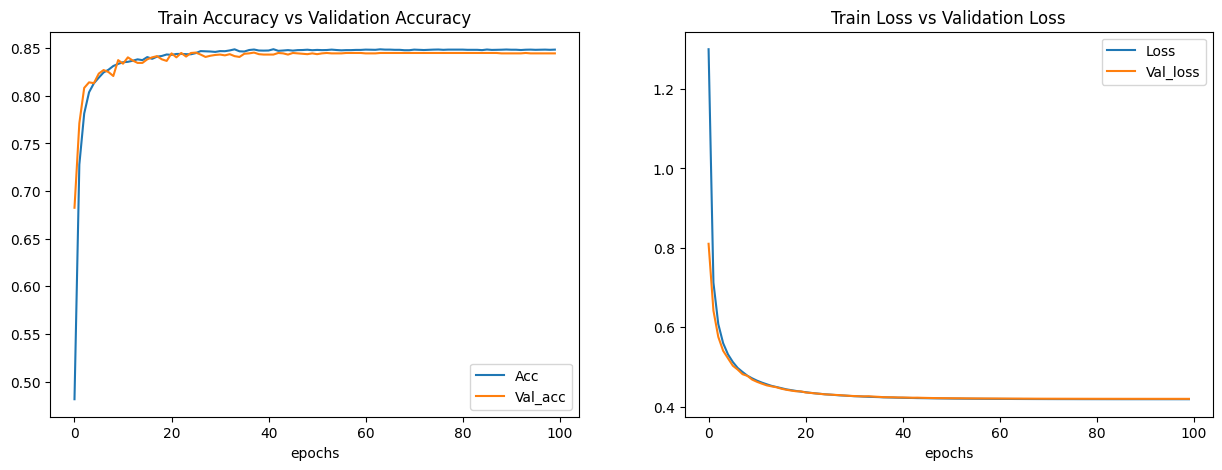

Training accuracy 0.8395447397232055
Validation accuracy 0.8394625067710877


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Train Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Train Loss vs Validation Loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))

#### Make Predictions against Test set

In [ ]:
# make predictions on the testing set
y_pred = modelc1.predict(testX, batch_size=32)
print(y_pred.shape  )
print(testY.shape)

94/94 [==============================] - 4s 20ms/step
(3000, 14)
(3000,)


(3000, 14)
(3000, 3)


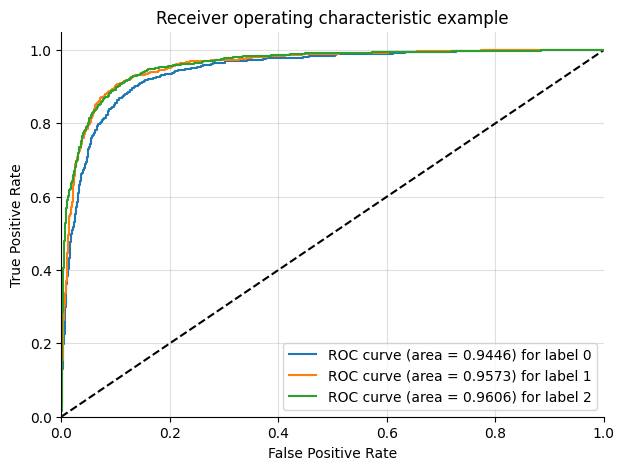

In [ ]:
from sklearn.preprocessing import label_binarize
def plot_multiclass_roc( testY, y_pred, n_classes, figsize=(12, 5)):


    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    ##y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    testY = label_binarize(testY, classes=[0,1,2])


    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(testY[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.4f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc( testY, y_pred, n_classes=3, figsize=(7,5 ))

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape  )
print(testY.shape)

print(classification_report(testY, y_pred, target_names=['Normal', 'Covid', 'Pneumonia'], digits=4))


(3000,)
(3000,)
              precision    recall  f1-score   support

      Normal     0.8221    0.8320    0.8270      1000
       Covid     0.8506    0.8600    0.8553      1000
   Pneumonia     0.8741    0.8540    0.8639      1000

    accuracy                         0.8487      3000
   macro avg     0.8490    0.8487    0.8488      3000
weighted avg     0.8490    0.8487    0.8488      3000



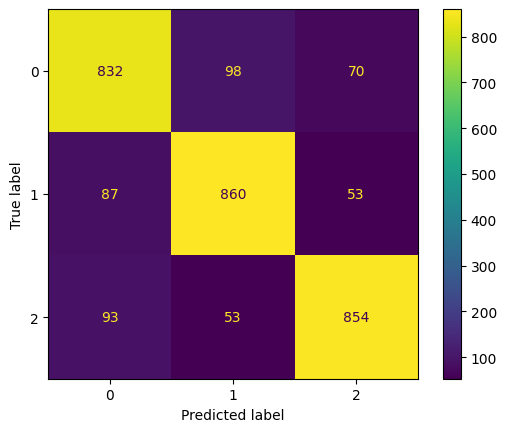


Test Accuracy: 0.8487


Test specificity Normal: 0.9100

Test specificity Covid: 0.9245

Test specificity Pnuemonia : 0.9385

Test specificity weighted average : 0.9234


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(testY, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Specificity = TN/TN + FP
####TN of C1" is all non-C1 instances that are not classified as C1.
#### "FP of C1" is all non-C1 instances that are classified as C1
specificity_normal = (cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2])/((cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2]) + (cm[1,0] + cm[2,0]))
specificity_covid = (cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0] )/((cm[0,0] + +cm[0,2] + cm[2,2] + cm[2,0]) + (cm[0,1] + cm[2,1]))
specificity_pnuemonia = (cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])/((cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1]) + (cm[0,2] + cm[1,2]))

specificity_weighted = (0.333 * specificity_normal) + (0.333 * specificity_covid) + (0.333 * specificity_pnuemonia)

# show the confusion matrix, accuracy, sensitivity, and specificity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nTest Accuracy: {:.4f}\n'.format(accuracy_score(testY, y_pred)))
print('\nTest specificity Normal: {:.4f}'.format(specificity_normal))
print('\nTest specificity Covid: {:.4f}'.format(specificity_covid))
print('\nTest specificity Pnuemonia : {:.4f}'.format(specificity_pnuemonia))
print('\nTest specificity weighted average : {:.4f}'.format(specificity_weighted))



### Experiment C2 - Learning rate reduced

In [ ]:
from tensorflow.keras.applications import densenet


base_modelc2 = densenet.DenseNet121(weights=None, include_top=False,
                       input_shape=(224, 224, 3), pooling="avg")

for layer in base_modelc2.layers:
    layer.trainable = False

output = tf.keras.layers.Dense(14, activation='softmax', name='output')(base_modelc2.layers[-1].output)
modelc2 = tf.keras.Model(inputs=[base_modelc2.input], outputs=[output])

## loading CheXNet weights
modelc2.load_weights("/content/gdrive/My Drive/CheXNet_Weights/CheXNet_Keras_0.3.0_weights.h5")


print("CheXNet loaded")

CheXNet loaded


In [ ]:

from tensorflow.keras.optimizers import SGD

import tensorflow as tf
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate= 1e-3,
    decay_steps=10000,
    decay_rate=0.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
modelc2.compile(optimizer,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=10),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

modelc2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [ ]:
epochs = 100

history = modelc2.fit(
  trainX, trainY,
  validation_data=(valX,valY),
  epochs=epochs,
  batch_size=32,
  callbacks = callbacks

)

Epoch 1/100
300/300 [==============================] - 19s 42ms/step - loss: 3.4490 - accuracy: 0.3543 - val_loss: 1.6585 - val_accuracy: 0.3658
Epoch 2/100
300/300 [==============================] - 9s 31ms/step - loss: 1.4882 - accuracy: 0.3465 - val_loss: 1.4079 - val_accuracy: 0.3533
Epoch 3/100
300/300 [==============================] - 9s 31ms/step - loss: 1.3558 - accuracy: 0.3576 - val_loss: 1.3151 - val_accuracy: 0.3629
Epoch 4/100
300/300 [==============================] - 9s 31ms/step - loss: 1.2817 - accuracy: 0.3714 - val_loss: 1.2535 - val_accuracy: 0.3821
Epoch 5/100
300/300 [==============================] - 9s 31ms/step - loss: 1.2294 - accuracy: 0.3854 - val_loss: 1.2083 - val_accuracy: 0.3983
Epoch 6/100
300/300 [==============================] - 9s 31ms/step - loss: 1.1907 - accuracy: 0.3986 - val_loss: 1.1741 - val_accuracy: 0.4092
Epoch 7/100
300/300 [==============================] - 9s 31ms/step - loss: 1.1611 - accuracy: 0.4090 - val_loss: 1.1479 - val_accuracy

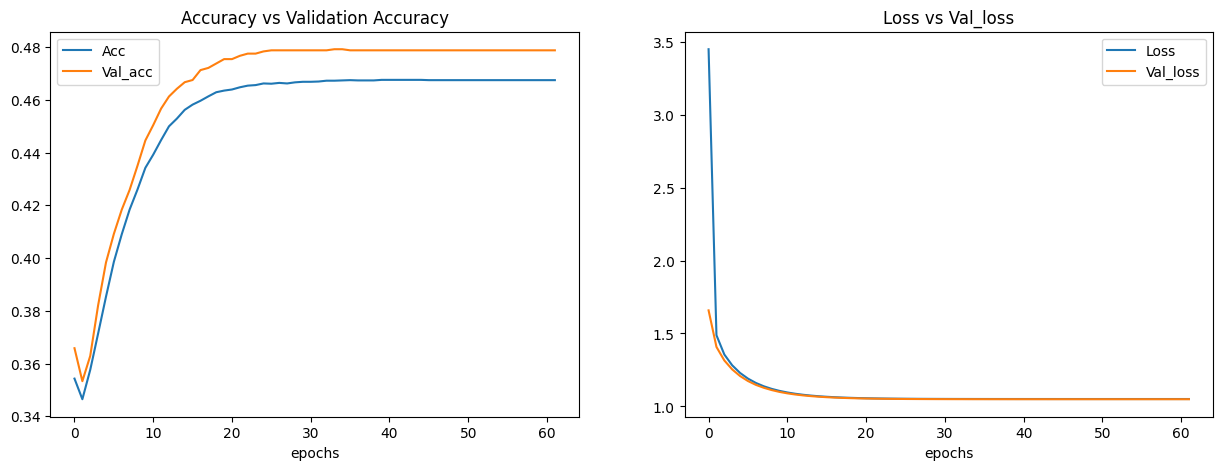

Training accuracy 0.4526530013930413
Validation accuracy 0.46378359583116346


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

print ('Training accuracy' , np.mean(history.history['accuracy']) )
print ('Validation accuracy' , np.mean(history.history['val_accuracy']))